In [1]:
import logging
# logging
logger = log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
logging.basicConfig()
log.info('%s logger started.', __name__)

INFO:__main__:__main__ logger started.


In [2]:
import os
import time
import gym
from gym import spaces
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import torch
# plotting
%matplotlib notebook
%matplotlib inline

/home/andy/miniconda3/envs/sblines3/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
start = time.time()

In [4]:
# 随机种子(random seeds) : 14,15,16,2025,3407,3408
seed5 = 3407

# 设置随机种子
np.random.seed(seed5)
random.seed(seed5)
torch.manual_seed(seed5)
torch.cuda.manual_seed(seed5)
torch.cuda.manual_seed_all(seed5)

# 保存这些种子值以便之后打印
seeds_dict = {
    'numpy_seed': seed5,
    'random_seed': seed5,
    'torch_seed': seed5,
    'cuda_seed': seed5,
    'cuda_all_seed': seed5
}

In [5]:
# params
window_length = 50
steps = 128
test_steps = 252  # 回测步数（一年）

In [6]:
# save dir
# save_dir = "./outputs/pytorch-DDPG/"
# os.makedirs(save_dir, exist_ok=True)

# Environment Definition

In [7]:
# from rl_portfolio_management.environments.portfolio import PortfolioEnv
from rl_portfolio_management.callbacks.notebook_plot import LivePlotNotebook
from rl_portfolio_management.config import eps

In [8]:
from rl_portfolio_management.util import sharpe

class DataSrc(object):
    """Acts as data provider for each new episode."""

    def __init__(self, 
                 df,
                 steps=252, 
                 scale=True, scale_extra_cols=True, augment=0.00, window_length=50, random_reset=True):
        """
        DataSrc.

        df - csv for data frame index of timestamps
             and multi-index columns levels=[['LTCBTC'],...],['open','low','high','close',...]]
             an example is included as an hdf file in this repository
        steps - total steps in episode
        scale - scale the data for each episode
        scale_extra_cols - scale extra columns by global mean and std
        augment - fraction to augment the data by
        random_reset - reset to a random time (otherwise continue through time)
        """
        self.steps = steps + 1
        self.augment = augment
        self.random_reset = random_reset
        self.scale = scale
        self.scale_extra_cols = scale_extra_cols
        self.window_length = window_length
        self.idx = self.window_length
        


        # get rid of NaN's
        df = df.copy()
        df.replace(np.nan, 0, inplace=True)
        df = df.fillna(method="pad")

        # dataframe to matrix
        self.asset_names = df.columns.levels[0].tolist()
        self.features = df.columns.levels[1].tolist()
        data = df.values.reshape(
            (len(df), len(self.asset_names), len(self.features)))
        self._data = np.transpose(data, (1, 0, 2))
        self._times = df.index

        self.price_columns = ['close', 'high', 'low', 'open']
        self.non_price_columns = set(
            df.columns.levels[1]) - set(self.price_columns)

        # Stats to let us normalize non price columns
        if scale_extra_cols:
            x = self._data.reshape((-1, len(self.features)))
            self.stats = dict(mean=x.mean(0), std=x.std(0))
            # for column in self._data.columns.levels[1].tolist():
            #     x = df.xs(key=column, axis=1, level='Price').as_matrix()[:, :]
            #     self.stats["mean"].append(x.mean())
            #      = dict(mean=x.mean(), std=x.std())

        self.reset()

    def _step(self):
        # get history matrix from dataframe
        data_window = self.data[:, self.step:self.step +
                                self.window_length].copy()

        # (eq.1) prices
        y1 = data_window[:, -1, 0] / data_window[:, -2, 0]
        y1 = np.concatenate([[1.0], y1])  # add cash price

        # (eq 18) X: prices are divided by close price
        nb_pc = len(self.price_columns)
        if self.scale:
            last_close_price = data_window[:, -1, 0]
            data_window[:, :, :nb_pc] /= last_close_price[:,
                                                          np.newaxis, np.newaxis]

        if self.scale_extra_cols:
            # normalize non price columns
            data_window[:, :, nb_pc:] -= self.stats["mean"][None, None, nb_pc:]
            data_window[:, :, nb_pc:] /= self.stats["std"][None, None, nb_pc:]
            data_window[:, :, nb_pc:] = np.clip(
                data_window[:, :, nb_pc:],
                self.stats["mean"][nb_pc:] - self.stats["std"][nb_pc:] * 10,
                self.stats["mean"][nb_pc:] + self.stats["std"][nb_pc:] * 10
            )
            data_window[np.isinf(data_window)] = 0
            data_window[np.isnan(data_window)] = 0

        self.step += 1
        history = data_window
        done = bool(self.step >= self.steps)

        return history, y1, done

    def reset(self):
        self.step = 0

        # get data for this episode
        if self.random_reset:
            self.idx = np.random.randint(
                low=self.window_length + 1, high=self._data.shape[1] - self.steps - 2)
        else:
            # 总是从数据集的起始位置开始（该功能主要用在测试集中）
            self.idx = self.window_length + 1
            
#             # continue sequentially, before reseting to start
#             if self.idx>(self._data.shape[1] - self.steps - self.window_length - 1):
#                 self.idx=self.window_length + 1
#             else:
#                 self.idx += self.steps

        data = self._data[:, self.idx -
                          self.window_length:self.idx + self.steps + 1].copy()
        self.times = self._times[self.idx -
                                 self.window_length:self.idx + self.steps + 1]

        # augment data to prevent overfitting
        data += np.random.normal(loc=0, scale=self.augment, size=data.shape)

        self.data = data


class PortfolioSim(object):
    """
    Portfolio management sim.

    Params:
    - cost e.g. 0.0015 

    Based of [Jiang 2017](https://arxiv.org/abs/1706.10059)
    """

    def __init__(self, asset_names=[], steps=128, trading_cost=0.0005, time_cost=0.0):
        self.cost = trading_cost
        self.time_cost = time_cost
        self.steps = steps
        self.asset_names = asset_names
        self.reset()

    def _step(self, w1, y1):
        """
        Step.

        w1 - new action of portfolio weights - e.g. [0.1,0.9, 0.0]
        y1 - price relative vector also called return
            e.g. [1.0, 0.9, 1.1]
        Numbered equations are from https://arxiv.org/abs/1706.10059
        """
        w0 = self.w0
        p0 = self.p0
        #
        # print("y1:",y1)
        # print("w1",w1)
        dw1 = (y1 * w0) / (np.dot(y1, np.abs(w0)) + eps)  # (eq7) weights evolve into
        # print("w0:",w0)
        # (eq16) cost to change portfolio
        # (excluding change in cash to avoid double counting for transaction cost)
        c1 = self.cost * (
            np.abs(dw1[1:] - w1[1:])).sum()

        p1 = p0 * (1 - c1) * np.exp(np.dot(np.log(y1), w0))  # (eq11) final portfolio value

        p1 = p1 * (1 - self.time_cost)  # we can add a cost to holding

        # can't have negative holdings in this model (no shorts)
        # p1 = np.clip(p1, 0, np.inf)

        rho1 = p1 / p0 - 1  # rate of returns
        r1 = np.log((p1 + eps) / (p0 + eps))  # (eq10) log rate of return
        # r1 = np.log(1 - c1) + np.dot(np.log(y1), w0)  # (eq10) log rate of return
        # (eq22) immediate reward is log rate of return scaled by episode length
        
        self.ret.append(r1) # 把收益率保存在容器中
        reward = sharpe(np.array(self.ret)) / self.steps
              

        # remember for next step
        self.w0 = w1
        self.p0 = p1


        # if we run out of money, we're done
        done = bool(p1 == 0)

        # should only return single values, not list
        info = {
            "reward": reward,
            "log_return": r1,
            "portfolio_value": p1,
            "market_return": y1.mean(),
            "rate_of_return": rho1,
            "weights_mean": w1.mean(),
            "weights_std": w1.std(),
            "cost": c1,
        }
        # record weights and prices
        for i, name in enumerate(['CASH'] + self.asset_names):
            info['weight_' + name] = w1[i]
            info['price_' + name] = y1[i]

        self.infos.append(info)
        return reward, info, done

    def reset(self):
        self.infos = []
        self.w0 = np.array([1.0] + [0.0] * len(self.asset_names))
        self.p0 = 1.0
        self.ret = [] # 定义一个容器，保存收益率，用作sharpe比率计算


class PortfolioEnv(gym.Env):
    """
    An environment for financial portfolio management.

    Financial portfolio management is the process of constant redistribution of a fund into different
    financial products.

    Based on [Huang 2020](https://arxiv.org/abs/2012.13773)
    """
    # Because of google colab, we cannot implement the GUI ('human' render mode)
    metadata = {'render.modes': ['notebook', 'ansi']}

    
    def __init__(self,
                 df,
                 steps=256,
                 trading_cost=0.0005,
                 time_cost=0.00,
                 window_length=50,
                 augment=0.00,
                 output_mode='DRLshort',
                 log_dir=None,
                 scale=True,
                 scale_extra_cols=True,
                 random_reset=True
                 ):
        """
        An environment for financial portfolio management.

        Params:
            df - csv for data frame index of timestamps
                 and multi-index columns levels=[['LTCBTC'],...],['open','low','high','close']]
            steps - steps in episode
            window_length - how many past observations["history"] to return
            trading_cost - cost of trade as a fraction,  e.g. 0.0025 corresponding to max rate of 0.25% at Poloniex (2017)
            time_cost - cost of holding as a fraction
            augment - fraction to randomly shift data by
            output_mode: decides observation["history"] shape
            - 'EIIE' for (assets, window, 3)
            - 'atari' for (window, window, 3) (assets is padded)
            - 'mlp' for (assets*window*3)
            log_dir: directory to save plots to
            scale - scales price data by last opening price on each episode (except return)
            scale_extra_cols - scales non price data using mean and std for whole dataset
        """
        super(PortfolioEnv, self).__init__()
        self.src = DataSrc(df=df, steps=steps, scale=scale, scale_extra_cols=scale_extra_cols,
                           augment=augment, window_length=window_length,
                           random_reset=random_reset)
        self._plot = self._plot2 = self._plot3 = None
        self.output_mode = output_mode
        self.sim = PortfolioSim(
            asset_names=self.src.asset_names,
            trading_cost=trading_cost,
            time_cost=time_cost,
            steps=steps)
        self.log_dir = log_dir

        # openai gym attributes
        # action will be the portfolio weights [cash_bias,w1,w2...] where wn are [-1, 1] for each asset
        nb_assets = len(self.src.asset_names)
        self.action_space = gym.spaces.Box(-1.0, 1.0, shape=(nb_assets + 1,), dtype=np.float32)
        
        # get the history space from the data min and max
        if output_mode == 'DRLshort':
            obs_shape = (
                nb_assets,
                window_length,
                len(self.src.features)
            )
            
        self.observation_space = gym.spaces.Dict({
            'history': gym.spaces.Box(
                -10,
                20 if scale else 1,  # if scale=True observed price changes return could be large fractions
                obs_shape
            ),
            'weights': self.action_space    
        })
        
    def reset(self):
        self.sim.reset()
        self.src.reset()
        self.infos = []
        action = self.sim.w0
        observation, reward, done, info = self.step(action)
        return observation
    
    def step(self, action):
        """
        Step the env.

        Actions should be portfolio [w0...]
        - Where wn is a portfolio weight between 0 and 1. The first (w0) is cash_bias
        - cn is the portfolio conversion weights see PortioSim._step for description
        """
        logger.debug('action: %s', action)
#         weights = np.clip(action, -1.0, 1.0)
#         weights[0] = np.clip(weights[0], 0, 1)
#         weights_abs = np.abs(weights)
#         weights /= weights_abs.sum() + eps
        # print('weights:',weights)
        weights = action
        if np.all(weights==0):
            weights[0] = 1        
        
        weights_abs = np.abs(weights)
        weights /= weights_abs.sum()

        # Sanity checks
        assert self.action_space.contains(
            action), 'action should be within %r but is %r' % (self.action_space, action)
        np.testing.assert_almost_equal(
            np.sum(np.abs(weights)), 1.0, 3, err_msg='weights should sum to 1. action="%s"' % weights)

        history, y1, done1 = self.src._step()

        reward, info, done2 = self.sim._step(weights, y1)

        # calculate return for buy and hold a bit of each asset
        info['market_value'] = np.cumprod(
            [inf["market_return"] for inf in self.infos + [info]])[-1]
        # add dates
        info['date'] = self.src.times[self.src.step].timestamp()
        info['steps'] = self.src.step

        self.infos.append(info)

        # reshape history according to output mode
        if self.output_mode == 'DRLshort':
            pass
        elif self.output_mode == 'atari':
            padding = history.shape[1] - history.shape[0]
            history = np.pad(history, [[0, padding], [
                0, 0], [0, 0]], mode='constant')
        elif self.output_mode == 'mlp':
            history = history.flatten()

        return {'history': history, 'weights': weights}, reward, done1 or done2, info
    
    def _seed(self, seed):
        np.random.seed(seed)
        return [seed]

    def render(self, mode='notebook', close=False):
        # if close:
            # return
        if mode == 'ansi':
            pprint(self.infos[-1])
        elif mode == 'notebook':
            self.plot_notebook(close)

    def plot_notebook(self, close=False):
        """Live plot using the jupyter notebook rendering of matplotlib."""

        if close:
            self._plot = self._plot2 = self._plot3 = None
            return

        df_info = pd.DataFrame(self.infos)
        df_info.index = pd.to_datetime(df_info["date"], unit='s')

        # plot prices and performance
        all_assets = ['CASH'] + self.sim.asset_names
        if not self._plot:
            colors = [None] * len(all_assets) + ['black']
            self._plot_dir = os.path.join(
                self.log_dir, 'notebook_plot_prices_' + str(time.time())) if self.log_dir else None
            self._plot = LivePlotNotebook(
                log_dir=self._plot_dir, title='prices & performance', labels=all_assets + ["Portfolio"], ylabel='value', colors=colors)
        x = df_info.index
        y_portfolio = df_info["portfolio_value"]
        y_assets = [df_info['price_' + name].cumprod()
                    for name in all_assets]
        self._plot.update(x, y_assets + [y_portfolio])


        # plot portfolio weights
        if not self._plot2:
            self._plot_dir2 = os.path.join(
                self.log_dir, 'notebook_plot_weights_' + str(time.time())) if self.log_dir else None
            self._plot2 = LivePlotNotebook(
                log_dir=self._plot_dir2, labels=all_assets, title='weights', ylabel='weight')
        ys = [df_info['weight_' + name] for name in all_assets]
        self._plot2.update(x, ys)

        # plot portfolio costs
        if not self._plot3:
            self._plot_dir3 = os.path.join(
                self.log_dir, 'notebook_plot_cost_' + str(time.time())) if self.log_dir else None
            self._plot3 = LivePlotNotebook(
                log_dir=self._plot_dir3, labels=['cost'], title='costs', ylabel='cost')
        ys = [df_info['cost']]
        self._plot3.update(x, ys)

        if close:
            self._plot = self._plot2 = self._plot3 = None



# APPLY ENV

In [9]:
from rl_portfolio_management.util import MDD, sharpe, softmax, MDD1, sortino, calmar, other_metrics
from rl_portfolio_management.wrappers import TanhActions, TransposeHistory, ConcatStates

df_train = pd.read_hdf('./data/usaStock_1d_vol.hf',key='train')
df_test = pd.read_hdf('./data/usaStock_1d_vol.hf',key='test')

In [10]:
import gym
class DeepRLWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.render_on_reset = False
        
        self.state_dim = self.observation_space.shape
        self.action_dim = self.action_space.shape[0]
        
        self.name = 'PortfolioEnv'
        self.success_threshold = 2
        
    def normalize_state(self, state):
        return state
    
    def step(self, action):
        state, reward, done, info =self.env.step(action)
#         reward*=1e4 # often reward scaling is important sooo...
        return state, reward, done, info
    
    def reset(self):        
        # here's a roundabout way to get it to plot on reset
        if self.render_on_reset: 
            self.env.render('notebook')

        return self.env.reset()

In [11]:
env = PortfolioEnv(df=df_train, steps=steps, output_mode='DRLshort')

In [12]:
def task_fn():
    env = PortfolioEnv(df=df_train, steps=steps, output_mode='DRLshort', random_reset=True)
    env = TransposeHistory(env)
    env = ConcatStates(env)
    env = TanhActions(env)
    env = DeepRLWrapper(env)
    return env

def task_fn_test(df=df_test, steps=test_steps):
    env = PortfolioEnv(df=df_test, steps=steps, output_mode='DRLshort', random_reset=False)
    env = TransposeHistory(env)
    env = ConcatStates(env)
    env = TanhActions(env)
    env = DeepRLWrapper(env)
    return env
    
# sanity check
task = task_fn()
task.reset().shape, task.step(task.action_space.sample())[0].shape

((4, 51, 10), (4, 51, 10))

In [13]:
# task.observation_space

In [14]:
# Instantiate the env
env = task_fn()

In [15]:
# env_test = task_fn_test()

try:
    env_test = task_fn_test(df=df_test, steps=test_steps)
except  ValueError:
    print("回测区间数据量不够，请增加回测数据")
    assert False, "程序执行终止"

In [16]:
# env_test.observation_space

In [17]:
from stable_baselines3.common.env_checker import check_env
# check_env(env)

In [18]:
# check_env(env_test)

In [19]:
# print(task.reset().shape[0])
# num_act = task.reset().shape[2] #env.action_space.shape[-1] - 1

In [20]:
import gym
import torch as th
import torch.nn as nn
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

# from rl_portfolio_management.customExtractor import CustomCNN

class CustomCNN(BaseFeaturesExtractor):
    """
    :param observation_space: (gym.Space)
    :param features_dim: (int) Number of features extracted.
        This corresponds to the number of unit for the last layer.
    """

    def __init__(self, 
                 observation_space: gym.spaces.Box, 
                 features_dim: int = 256):
        super(CustomCNN, self).__init__(observation_space, features_dim)
        # We assume CxHxW images (channels first)
        # Re-ordering will be done by pre-preprocessing or wrapper       
        n_input_channels = observation_space.shape[0]
#         num_act = observation_space.shape[2]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 64, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, ceil_mode=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, ceil_mode=True),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, ceil_mode=True),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with th.no_grad():
            n_flatten = self.cnn(
                th.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim, bias=True), nn.ReLU())

    def forward(self, observations: th.Tensor) -> th.Tensor:
        return self.linear(self.cnn(observations))

In [21]:
from typing import Callable, Dict, List, Optional, Tuple, Type, Union
from stable_baselines3.common.policies import ActorCriticPolicy
# from stable_baselines3.common.policies import BaseModel, BasePolicy, create_sde_features_extractor, register_policy
# from stable_baselines3.td3.policies import Actor, TD3Policy
# from stable_baselines3.common.preprocessing import get_action_dim

In [22]:
# class CustomNetwork(nn.Module):
#     """
#     Custom network for policy and value function.
#     It receives as input the features extracted by the feature extractor.

#     :param feature_dim: dimension of the features extracted with the features_extractor (e.g. features from a CNN)
#     :param last_layer_dim_pi: (int) number of units for the last layer of the policy network
#     :param last_layer_dim_vf: (int) number of units for the last layer of the value network
#     """

#     def __init__(
#         self,
#         feature_dim: int,
#         last_layer_dim_pi: int = 64,
#         last_layer_dim_vf: int = 64,
#     ):
#         super(CustomNetwork, self).__init__()
        
#         # IMPORTANT:
#         # Save output dimensions, used to create the distributions
#         self.latent_dim_pi = last_layer_dim_pi
#         self.latent_dim_vf = last_layer_dim_vf
#         dropout_half = nn.Dropout(p=0.5)

#         # Policy network
#         self.policy_net = nn.Sequential(
#             nn.Linear(feature_dim, 256), 
#             nn.ReLU(),
#             dropout_half,
#             nn.Linear(256, 128), 
#             nn.ReLU(),
#             dropout_half,
#             nn.Linear(128, last_layer_dim_pi), 
#         )
#         # Value network
#         self.value_net = nn.Sequential(
#             nn.Linear(feature_dim, 128), 
#             nn.ReLU(),
#             dropout_half,
#             nn.Linear(128, 64), 
#             nn.ReLU(),
#             dropout_half,
#             nn.Linear(64, last_layer_dim_vf), 
#         )

#     def forward(self, features: th.Tensor) -> Tuple[th.Tensor, th.Tensor]:
#         """
#         :return: (th.Tensor, th.Tensor) latent_policy, latent_value of the specified network.
#             If all layers are shared, then ``latent_policy == latent_value``
#         """
#         return self.policy_net(features), self.value_net(features)


# class CustomActorCriticPolicy(ActorCriticPolicy):
#     def __init__(
#         self,
#         observation_space: gym.spaces.Space,
#         action_space: gym.spaces.Space,
#         lr_schedule: Callable[[float], float],
#         net_arch: Optional[List[Union[int, Dict[str, List[int]]]]] = None,
#         activation_fn: Type[nn.Module] = nn.Tanh,
#         *args,
#         **kwargs,
#     ):

#         super(CustomActorCriticPolicy, self).__init__(
#             observation_space,
#             action_space,
#             lr_schedule,
#             net_arch,
#             activation_fn,
#             # Pass remaining arguments to base class
#             *args,
#             **kwargs,
#         )
#         # Disable orthogonal initialization
#         self.ortho_init = False

#     def _build_mlp_extractor(self) -> None:
#         self.mlp_extractor = CustomNetwork(self.features_dim,
#                                            last_layer_dim_pi = env.action_space.shape[-1],
#                                            last_layer_dim_vf = 1,
#                                           )
        

In [23]:
from stable_baselines3 import PPO, DDPG, TD3
# from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

# The noise objects for DDPG
# n_actions = env.action_space.shape[-1]
# action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.3 * np.ones(n_actions))
# lr_schedule = [[4e-5],5e-4]

policy_kwargs = dict(
    features_extractor_class=CustomCNN,
    features_extractor_kwargs=dict(features_dim=1024),
    net_arch=[dict(pi=[128,128],vf=[128,128])],
)

In [24]:
model = PPO('MlpPolicy', env, policy_kwargs=policy_kwargs,
            tensorboard_log="./runs/PPO-vgg1-Tanh-maxSharpe-arbitrage-seed5",
            batch_size=256,
#             learning_rate=1e-4,
            verbose=1)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [25]:
# model = TD3(CustomTD3Policy, env, policy_kwargs=policy_kwargs, verbose=1)

In [26]:
model.learn(6000000) 

Logging to ./runs/PPO-vgg1-Tanh-maxSharpe-arbitrage-seed5/PPO_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 128      |
|    ep_rew_mean     | -2.43    |
| time/              |          |
|    fps             | 571      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -1.7         |
| time/                   |              |
|    fps                  | 543          |
|    iterations           | 2            |
|    time_elapsed         | 7            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0057736794 |
|    clip_fraction        | 0.0655       |
|    clip_range           | 0.2          |
|    entropy_loss         | -15.6    

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -1.41        |
| time/                   |              |
|    fps                  | 532          |
|    iterations           | 11           |
|    time_elapsed         | 42           |
|    total_timesteps      | 22528        |
| train/                  |              |
|    approx_kl            | 0.0068986653 |
|    clip_fraction        | 0.0896       |
|    clip_range           | 0.2          |
|    entropy_loss         | -15.6        |
|    explained_variance   | 5.66e-06     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0567       |
|    n_updates            | 100          |
|    policy_gradient_loss | -0.00743     |
|    std                  | 1            |
|    value_loss           | 0.118        |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -1.61        |
| time/                   |              |
|    fps                  | 533          |
|    iterations           | 20           |
|    time_elapsed         | 76           |
|    total_timesteps      | 40960        |
| train/                  |              |
|    approx_kl            | 0.0063000303 |
|    clip_fraction        | 0.0665       |
|    clip_range           | 0.2          |
|    entropy_loss         | -15.4        |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0299       |
|    n_updates            | 190          |
|    policy_gradient_loss | -0.00589     |
|    std                  | 0.983        |
|    value_loss           | 0.0875       |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -1.9        |
| time/                   |             |
|    fps                  | 532         |
|    iterations           | 29          |
|    time_elapsed         | 111         |
|    total_timesteps      | 59392       |
| train/                  |             |
|    approx_kl            | 0.004160824 |
|    clip_fraction        | 0.0327      |
|    clip_range           | 0.2         |
|    entropy_loss         | -15.4       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0365      |
|    n_updates            | 280         |
|    policy_gradient_loss | -0.00347    |
|    std                  | 0.985       |
|    value_loss           | 0.0946      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -1.54       |
| time/                   |             |
|    fps                  | 532         |
|    iterations           | 38          |
|    time_elapsed         | 146         |
|    total_timesteps      | 77824       |
| train/                  |             |
|    approx_kl            | 0.007273957 |
|    clip_fraction        | 0.0651      |
|    clip_range           | 0.2         |
|    entropy_loss         | -15.4       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0525      |
|    n_updates            | 370         |
|    policy_gradient_loss | -0.00506    |
|    std                  | 0.98        |
|    value_loss           | 0.107       |
-----------------------------------------
---------------------------------------
| rollout/                |         

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -1.54        |
| time/                   |              |
|    fps                  | 532          |
|    iterations           | 47           |
|    time_elapsed         | 180          |
|    total_timesteps      | 96256        |
| train/                  |              |
|    approx_kl            | 0.0060729855 |
|    clip_fraction        | 0.057        |
|    clip_range           | 0.2          |
|    entropy_loss         | -15.3        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.066        |
|    n_updates            | 460          |
|    policy_gradient_loss | -0.00652     |
|    std                  | 0.97         |
|    value_loss           | 0.124        |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -1.49        |
| time/                   |              |
|    fps                  | 532          |
|    iterations           | 56           |
|    time_elapsed         | 215          |
|    total_timesteps      | 114688       |
| train/                  |              |
|    approx_kl            | 0.0054717856 |
|    clip_fraction        | 0.0524       |
|    clip_range           | 0.2          |
|    entropy_loss         | -15.2        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0388       |
|    n_updates            | 550          |
|    policy_gradient_loss | -0.00426     |
|    std                  | 0.963        |
|    value_loss           | 0.0635       |
------------------------------------------
----------------------------------------
| rollout/   

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -1.4         |
| time/                   |              |
|    fps                  | 532          |
|    iterations           | 65           |
|    time_elapsed         | 249          |
|    total_timesteps      | 133120       |
| train/                  |              |
|    approx_kl            | 0.0059326105 |
|    clip_fraction        | 0.046        |
|    clip_range           | 0.2          |
|    entropy_loss         | -15.2        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0585       |
|    n_updates            | 640          |
|    policy_gradient_loss | -0.00417     |
|    std                  | 0.961        |
|    value_loss           | 0.14         |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -1.73        |
| time/                   |              |
|    fps                  | 532          |
|    iterations           | 74           |
|    time_elapsed         | 284          |
|    total_timesteps      | 151552       |
| train/                  |              |
|    approx_kl            | 0.0043999413 |
|    clip_fraction        | 0.0475       |
|    clip_range           | 0.2          |
|    entropy_loss         | -15          |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0327       |
|    n_updates            | 730          |
|    policy_gradient_loss | -0.00442     |
|    std                  | 0.948        |
|    value_loss           | 0.0803       |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -1.87        |
| time/                   |              |
|    fps                  | 532          |
|    iterations           | 83           |
|    time_elapsed         | 319          |
|    total_timesteps      | 169984       |
| train/                  |              |
|    approx_kl            | 0.0061904932 |
|    clip_fraction        | 0.0505       |
|    clip_range           | 0.2          |
|    entropy_loss         | -14.9        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0502       |
|    n_updates            | 820          |
|    policy_gradient_loss | -0.00316     |
|    std                  | 0.936        |
|    value_loss           | 0.111        |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -1.52        |
| time/                   |              |
|    fps                  | 532          |
|    iterations           | 92           |
|    time_elapsed         | 353          |
|    total_timesteps      | 188416       |
| train/                  |              |
|    approx_kl            | 0.0057478007 |
|    clip_fraction        | 0.0485       |
|    clip_range           | 0.2          |
|    entropy_loss         | -14.8        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.021        |
|    n_updates            | 910          |
|    policy_gradient_loss | -0.00477     |
|    std                  | 0.934        |
|    value_loss           | 0.0684       |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -1.08       |
| time/                   |             |
|    fps                  | 532         |
|    iterations           | 101         |
|    time_elapsed         | 388         |
|    total_timesteps      | 206848      |
| train/                  |             |
|    approx_kl            | 0.004776772 |
|    clip_fraction        | 0.0515      |
|    clip_range           | 0.2         |
|    entropy_loss         | -14.9       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0344      |
|    n_updates            | 1000        |
|    policy_gradient_loss | -0.00381    |
|    std                  | 0.938       |
|    value_loss           | 0.0676      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -1.17        |
| time/                   |              |
|    fps                  | 533          |
|    iterations           | 110          |
|    time_elapsed         | 422          |
|    total_timesteps      | 225280       |
| train/                  |              |
|    approx_kl            | 0.0062055206 |
|    clip_fraction        | 0.0457       |
|    clip_range           | 0.2          |
|    entropy_loss         | -14.9        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0294       |
|    n_updates            | 1090         |
|    policy_gradient_loss | -0.00416     |
|    std                  | 0.943        |
|    value_loss           | 0.0669       |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -1.51        |
| time/                   |              |
|    fps                  | 533          |
|    iterations           | 119          |
|    time_elapsed         | 456          |
|    total_timesteps      | 243712       |
| train/                  |              |
|    approx_kl            | 0.0061434433 |
|    clip_fraction        | 0.0587       |
|    clip_range           | 0.2          |
|    entropy_loss         | -15          |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0298       |
|    n_updates            | 1180         |
|    policy_gradient_loss | -0.00577     |
|    std                  | 0.946        |
|    value_loss           | 0.0744       |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -1.32        |
| time/                   |              |
|    fps                  | 533          |
|    iterations           | 128          |
|    time_elapsed         | 491          |
|    total_timesteps      | 262144       |
| train/                  |              |
|    approx_kl            | 0.0050196825 |
|    clip_fraction        | 0.0408       |
|    clip_range           | 0.2          |
|    entropy_loss         | -15          |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0061       |
|    n_updates            | 1270         |
|    policy_gradient_loss | -0.00467     |
|    std                  | 0.944        |
|    value_loss           | 0.0654       |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -1.66        |
| time/                   |              |
|    fps                  | 533          |
|    iterations           | 137          |
|    time_elapsed         | 525          |
|    total_timesteps      | 280576       |
| train/                  |              |
|    approx_kl            | 0.0056921938 |
|    clip_fraction        | 0.0447       |
|    clip_range           | 0.2          |
|    entropy_loss         | -14.9        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0421       |
|    n_updates            | 1360         |
|    policy_gradient_loss | -0.00405     |
|    std                  | 0.942        |
|    value_loss           | 0.0713       |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -1.17        |
| time/                   |              |
|    fps                  | 533          |
|    iterations           | 146          |
|    time_elapsed         | 560          |
|    total_timesteps      | 299008       |
| train/                  |              |
|    approx_kl            | 0.0068497946 |
|    clip_fraction        | 0.0725       |
|    clip_range           | 0.2          |
|    entropy_loss         | -14.8        |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0357       |
|    n_updates            | 1450         |
|    policy_gradient_loss | -0.00603     |
|    std                  | 0.931        |
|    value_loss           | 0.0847       |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -1.24        |
| time/                   |              |
|    fps                  | 533          |
|    iterations           | 155          |
|    time_elapsed         | 594          |
|    total_timesteps      | 317440       |
| train/                  |              |
|    approx_kl            | 0.0056703477 |
|    clip_fraction        | 0.0411       |
|    clip_range           | 0.2          |
|    entropy_loss         | -14.7        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0319       |
|    n_updates            | 1540         |
|    policy_gradient_loss | -0.00386     |
|    std                  | 0.924        |
|    value_loss           | 0.073        |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -1.24        |
| time/                   |              |
|    fps                  | 533          |
|    iterations           | 164          |
|    time_elapsed         | 629          |
|    total_timesteps      | 335872       |
| train/                  |              |
|    approx_kl            | 0.0073467987 |
|    clip_fraction        | 0.0711       |
|    clip_range           | 0.2          |
|    entropy_loss         | -14.7        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0312       |
|    n_updates            | 1630         |
|    policy_gradient_loss | -0.0061      |
|    std                  | 0.921        |
|    value_loss           | 0.0726       |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -1.43       |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 173         |
|    time_elapsed         | 663         |
|    total_timesteps      | 354304      |
| train/                  |             |
|    approx_kl            | 0.007415085 |
|    clip_fraction        | 0.0535      |
|    clip_range           | 0.2         |
|    entropy_loss         | -14.7       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0572      |
|    n_updates            | 1720        |
|    policy_gradient_loss | -0.00421    |
|    std                  | 0.923       |
|    value_loss           | 0.127       |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -1.7         |
| time/                   |              |
|    fps                  | 533          |
|    iterations           | 182          |
|    time_elapsed         | 698          |
|    total_timesteps      | 372736       |
| train/                  |              |
|    approx_kl            | 0.0060050883 |
|    clip_fraction        | 0.0463       |
|    clip_range           | 0.2          |
|    entropy_loss         | -14.6        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0215       |
|    n_updates            | 1810         |
|    policy_gradient_loss | -0.00418     |
|    std                  | 0.912        |
|    value_loss           | 0.0726       |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -1.64       |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 191         |
|    time_elapsed         | 732         |
|    total_timesteps      | 391168      |
| train/                  |             |
|    approx_kl            | 0.005260326 |
|    clip_fraction        | 0.0396      |
|    clip_range           | 0.2         |
|    entropy_loss         | -14.5       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0635      |
|    n_updates            | 1900        |
|    policy_gradient_loss | -0.0032     |
|    std                  | 0.904       |
|    value_loss           | 0.117       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -1.39       |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 200         |
|    time_elapsed         | 767         |
|    total_timesteps      | 409600      |
| train/                  |             |
|    approx_kl            | 0.005915666 |
|    clip_fraction        | 0.0506      |
|    clip_range           | 0.2         |
|    entropy_loss         | -14.4       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0611      |
|    n_updates            | 1990        |
|    policy_gradient_loss | -0.00367    |
|    std                  | 0.901       |
|    value_loss           | 0.145       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -1.44      |
| time/                   |            |
|    fps                  | 533        |
|    iterations           | 209        |
|    time_elapsed         | 801        |
|    total_timesteps      | 428032     |
| train/                  |            |
|    approx_kl            | 0.00600591 |
|    clip_fraction        | 0.0409     |
|    clip_range           | 0.2        |
|    entropy_loss         | -14.4      |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0356     |
|    n_updates            | 2080       |
|    policy_gradient_loss | -0.00323   |
|    std                  | 0.9        |
|    value_loss           | 0.0826     |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_me

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -1.53        |
| time/                   |              |
|    fps                  | 533          |
|    iterations           | 218          |
|    time_elapsed         | 836          |
|    total_timesteps      | 446464       |
| train/                  |              |
|    approx_kl            | 0.0074963737 |
|    clip_fraction        | 0.0608       |
|    clip_range           | 0.2          |
|    entropy_loss         | -14.3        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0096       |
|    n_updates            | 2170         |
|    policy_gradient_loss | -0.00563     |
|    std                  | 0.891        |
|    value_loss           | 0.0734       |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -1.56        |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 227          |
|    time_elapsed         | 870          |
|    total_timesteps      | 464896       |
| train/                  |              |
|    approx_kl            | 0.0067470614 |
|    clip_fraction        | 0.0719       |
|    clip_range           | 0.2          |
|    entropy_loss         | -14.4        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0538       |
|    n_updates            | 2260         |
|    policy_gradient_loss | -0.00663     |
|    std                  | 0.901        |
|    value_loss           | 0.113        |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -1.52        |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 236          |
|    time_elapsed         | 905          |
|    total_timesteps      | 483328       |
| train/                  |              |
|    approx_kl            | 0.0064435615 |
|    clip_fraction        | 0.0609       |
|    clip_range           | 0.2          |
|    entropy_loss         | -14.2        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0342       |
|    n_updates            | 2350         |
|    policy_gradient_loss | -0.00484     |
|    std                  | 0.887        |
|    value_loss           | 0.0834       |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -1.18       |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 245         |
|    time_elapsed         | 939         |
|    total_timesteps      | 501760      |
| train/                  |             |
|    approx_kl            | 0.006653341 |
|    clip_fraction        | 0.066       |
|    clip_range           | 0.2         |
|    entropy_loss         | -14         |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0323      |
|    n_updates            | 2440        |
|    policy_gradient_loss | -0.00627    |
|    std                  | 0.87        |
|    value_loss           | 0.0758      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -1.25        |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 254          |
|    time_elapsed         | 973          |
|    total_timesteps      | 520192       |
| train/                  |              |
|    approx_kl            | 0.0055798106 |
|    clip_fraction        | 0.0492       |
|    clip_range           | 0.2          |
|    entropy_loss         | -14          |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0266       |
|    n_updates            | 2530         |
|    policy_gradient_loss | -0.00448     |
|    std                  | 0.866        |
|    value_loss           | 0.0783       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -1.18       |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 263         |
|    time_elapsed         | 1008        |
|    total_timesteps      | 538624      |
| train/                  |             |
|    approx_kl            | 0.005651319 |
|    clip_fraction        | 0.0434      |
|    clip_range           | 0.2         |
|    entropy_loss         | -13.9       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0461      |
|    n_updates            | 2620        |
|    policy_gradient_loss | -0.00316    |
|    std                  | 0.862       |
|    value_loss           | 0.0832      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -1.62       |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 272         |
|    time_elapsed         | 1042        |
|    total_timesteps      | 557056      |
| train/                  |             |
|    approx_kl            | 0.007302225 |
|    clip_fraction        | 0.0578      |
|    clip_range           | 0.2         |
|    entropy_loss         | -13.9       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0476      |
|    n_updates            | 2710        |
|    policy_gradient_loss | -0.00393    |
|    std                  | 0.861       |
|    value_loss           | 0.0886      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -1.22       |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 281         |
|    time_elapsed         | 1077        |
|    total_timesteps      | 575488      |
| train/                  |             |
|    approx_kl            | 0.005294103 |
|    clip_fraction        | 0.0534      |
|    clip_range           | 0.2         |
|    entropy_loss         | -13.8       |
|    explained_variance   | 1.19e-07    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0421      |
|    n_updates            | 2800        |
|    policy_gradient_loss | -0.00438    |
|    std                  | 0.852       |
|    value_loss           | 0.0722      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -1.23       |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 290         |
|    time_elapsed         | 1111        |
|    total_timesteps      | 593920      |
| train/                  |             |
|    approx_kl            | 0.007484644 |
|    clip_fraction        | 0.0759      |
|    clip_range           | 0.2         |
|    entropy_loss         | -13.6       |
|    explained_variance   | 1.79e-07    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0276      |
|    n_updates            | 2890        |
|    policy_gradient_loss | -0.00731    |
|    std                  | 0.839       |
|    value_loss           | 0.0922      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -1.09        |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 299          |
|    time_elapsed         | 1146         |
|    total_timesteps      | 612352       |
| train/                  |              |
|    approx_kl            | 0.0059495782 |
|    clip_fraction        | 0.0468       |
|    clip_range           | 0.2          |
|    entropy_loss         | -13.5        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0229       |
|    n_updates            | 2980         |
|    policy_gradient_loss | -0.0038      |
|    std                  | 0.831        |
|    value_loss           | 0.0638       |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.983       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 308          |
|    time_elapsed         | 1180         |
|    total_timesteps      | 630784       |
| train/                  |              |
|    approx_kl            | 0.0058352025 |
|    clip_fraction        | 0.056        |
|    clip_range           | 0.2          |
|    entropy_loss         | -13.5        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0196       |
|    n_updates            | 3070         |
|    policy_gradient_loss | -0.00503     |
|    std                  | 0.829        |
|    value_loss           | 0.0468       |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -1.34       |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 317         |
|    time_elapsed         | 1215        |
|    total_timesteps      | 649216      |
| train/                  |             |
|    approx_kl            | 0.006619608 |
|    clip_fraction        | 0.0707      |
|    clip_range           | 0.2         |
|    entropy_loss         | -13.3       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0213      |
|    n_updates            | 3160        |
|    policy_gradient_loss | -0.00565    |
|    std                  | 0.814       |
|    value_loss           | 0.0804      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -1.56        |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 326          |
|    time_elapsed         | 1249         |
|    total_timesteps      | 667648       |
| train/                  |              |
|    approx_kl            | 0.0061168415 |
|    clip_fraction        | 0.0523       |
|    clip_range           | 0.2          |
|    entropy_loss         | -13.2        |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0495       |
|    n_updates            | 3250         |
|    policy_gradient_loss | -0.00432     |
|    std                  | 0.805        |
|    value_loss           | 0.108        |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -1.05       |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 335         |
|    time_elapsed         | 1283        |
|    total_timesteps      | 686080      |
| train/                  |             |
|    approx_kl            | 0.005473464 |
|    clip_fraction        | 0.0625      |
|    clip_range           | 0.2         |
|    entropy_loss         | -13.1       |
|    explained_variance   | 5.96e-08    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0172      |
|    n_updates            | 3340        |
|    policy_gradient_loss | -0.00605    |
|    std                  | 0.802       |
|    value_loss           | 0.0456      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -1.38       |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 344         |
|    time_elapsed         | 1318        |
|    total_timesteps      | 704512      |
| train/                  |             |
|    approx_kl            | 0.005672653 |
|    clip_fraction        | 0.0494      |
|    clip_range           | 0.2         |
|    entropy_loss         | -13.1       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0319      |
|    n_updates            | 3430        |
|    policy_gradient_loss | -0.00394    |
|    std                  | 0.801       |
|    value_loss           | 0.0803      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -1.21        |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 353          |
|    time_elapsed         | 1352         |
|    total_timesteps      | 722944       |
| train/                  |              |
|    approx_kl            | 0.0068248645 |
|    clip_fraction        | 0.0765       |
|    clip_range           | 0.2          |
|    entropy_loss         | -13          |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0188       |
|    n_updates            | 3520         |
|    policy_gradient_loss | -0.00654     |
|    std                  | 0.793        |
|    value_loss           | 0.0505       |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -1.16        |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 362          |
|    time_elapsed         | 1387         |
|    total_timesteps      | 741376       |
| train/                  |              |
|    approx_kl            | 0.0071264138 |
|    clip_fraction        | 0.0882       |
|    clip_range           | 0.2          |
|    entropy_loss         | -13          |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0361       |
|    n_updates            | 3610         |
|    policy_gradient_loss | -0.00685     |
|    std                  | 0.79         |
|    value_loss           | 0.0706       |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -1.13       |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 371         |
|    time_elapsed         | 1421        |
|    total_timesteps      | 759808      |
| train/                  |             |
|    approx_kl            | 0.006093722 |
|    clip_fraction        | 0.0479      |
|    clip_range           | 0.2         |
|    entropy_loss         | -13         |
|    explained_variance   | 5.96e-08    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0257      |
|    n_updates            | 3700        |
|    policy_gradient_loss | -0.00293    |
|    std                  | 0.794       |
|    value_loss           | 0.0616      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.757      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 380         |
|    time_elapsed         | 1456        |
|    total_timesteps      | 778240      |
| train/                  |             |
|    approx_kl            | 0.006415315 |
|    clip_fraction        | 0.0707      |
|    clip_range           | 0.2         |
|    entropy_loss         | -13         |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0325      |
|    n_updates            | 3790        |
|    policy_gradient_loss | -0.00595    |
|    std                  | 0.793       |
|    value_loss           | 0.0639      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.845       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 389          |
|    time_elapsed         | 1490         |
|    total_timesteps      | 796672       |
| train/                  |              |
|    approx_kl            | 0.0065331804 |
|    clip_fraction        | 0.0627       |
|    clip_range           | 0.2          |
|    entropy_loss         | -12.9        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0147       |
|    n_updates            | 3880         |
|    policy_gradient_loss | -0.00428     |
|    std                  | 0.786        |
|    value_loss           | 0.0445       |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.931       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 398          |
|    time_elapsed         | 1525         |
|    total_timesteps      | 815104       |
| train/                  |              |
|    approx_kl            | 0.0072858334 |
|    clip_fraction        | 0.0646       |
|    clip_range           | 0.2          |
|    entropy_loss         | -12.9        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0142       |
|    n_updates            | 3970         |
|    policy_gradient_loss | -0.00526     |
|    std                  | 0.783        |
|    value_loss           | 0.0501       |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -1.18       |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 407         |
|    time_elapsed         | 1559        |
|    total_timesteps      | 833536      |
| train/                  |             |
|    approx_kl            | 0.006651367 |
|    clip_fraction        | 0.0708      |
|    clip_range           | 0.2         |
|    entropy_loss         | -12.9       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0246      |
|    n_updates            | 4060        |
|    policy_gradient_loss | -0.00673    |
|    std                  | 0.784       |
|    value_loss           | 0.0799      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -1.32        |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 416          |
|    time_elapsed         | 1594         |
|    total_timesteps      | 851968       |
| train/                  |              |
|    approx_kl            | 0.0062085018 |
|    clip_fraction        | 0.0638       |
|    clip_range           | 0.2          |
|    entropy_loss         | -12.8        |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0471       |
|    n_updates            | 4150         |
|    policy_gradient_loss | -0.00527     |
|    std                  | 0.779        |
|    value_loss           | 0.0934       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -1.06       |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 425         |
|    time_elapsed         | 1628        |
|    total_timesteps      | 870400      |
| train/                  |             |
|    approx_kl            | 0.007180264 |
|    clip_fraction        | 0.0666      |
|    clip_range           | 0.2         |
|    entropy_loss         | -12.7       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.039       |
|    n_updates            | 4240        |
|    policy_gradient_loss | -0.00595    |
|    std                  | 0.772       |
|    value_loss           | 0.068       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.677      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 434         |
|    time_elapsed         | 1663        |
|    total_timesteps      | 888832      |
| train/                  |             |
|    approx_kl            | 0.006393592 |
|    clip_fraction        | 0.073       |
|    clip_range           | 0.2         |
|    entropy_loss         | -12.6       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0372      |
|    n_updates            | 4330        |
|    policy_gradient_loss | -0.00625    |
|    std                  | 0.761       |
|    value_loss           | 0.0837      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -1.05        |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 443          |
|    time_elapsed         | 1697         |
|    total_timesteps      | 907264       |
| train/                  |              |
|    approx_kl            | 0.0060231737 |
|    clip_fraction        | 0.0512       |
|    clip_range           | 0.2          |
|    entropy_loss         | -12.5        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 0.039        |
|    n_updates            | 4420         |
|    policy_gradient_loss | -0.00397     |
|    std                  | 0.758        |
|    value_loss           | 0.0774       |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.731       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 452          |
|    time_elapsed         | 1732         |
|    total_timesteps      | 925696       |
| train/                  |              |
|    approx_kl            | 0.0043509286 |
|    clip_fraction        | 0.0458       |
|    clip_range           | 0.2          |
|    entropy_loss         | -12.4        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0285       |
|    n_updates            | 4510         |
|    policy_gradient_loss | -0.00374     |
|    std                  | 0.751        |
|    value_loss           | 0.0638       |
------------------------------------------
------------------------------------------
| rollout/ 

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -0.694     |
| time/                   |            |
|    fps                  | 534        |
|    iterations           | 461        |
|    time_elapsed         | 1766       |
|    total_timesteps      | 944128     |
| train/                  |            |
|    approx_kl            | 0.00728106 |
|    clip_fraction        | 0.0711     |
|    clip_range           | 0.2        |
|    entropy_loss         | -12.3      |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | 0.041      |
|    n_updates            | 4600       |
|    policy_gradient_loss | -0.00581   |
|    std                  | 0.742      |
|    value_loss           | 0.0869     |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_me

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.675       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 470          |
|    time_elapsed         | 1801         |
|    total_timesteps      | 962560       |
| train/                  |              |
|    approx_kl            | 0.0058742804 |
|    clip_fraction        | 0.0563       |
|    clip_range           | 0.2          |
|    entropy_loss         | -12.1        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0299       |
|    n_updates            | 4690         |
|    policy_gradient_loss | -0.00429     |
|    std                  | 0.728        |
|    value_loss           | 0.0658       |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.92        |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 479          |
|    time_elapsed         | 1835         |
|    total_timesteps      | 980992       |
| train/                  |              |
|    approx_kl            | 0.0066419435 |
|    clip_fraction        | 0.0677       |
|    clip_range           | 0.2          |
|    entropy_loss         | -12          |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0212       |
|    n_updates            | 4780         |
|    policy_gradient_loss | -0.00594     |
|    std                  | 0.725        |
|    value_loss           | 0.0785       |
------------------------------------------
----------------------------------------
| rollout/   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.947      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 488         |
|    time_elapsed         | 1870        |
|    total_timesteps      | 999424      |
| train/                  |             |
|    approx_kl            | 0.006631734 |
|    clip_fraction        | 0.0641      |
|    clip_range           | 0.2         |
|    entropy_loss         | -12         |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0236      |
|    n_updates            | 4870        |
|    policy_gradient_loss | -0.00468    |
|    std                  | 0.725       |
|    value_loss           | 0.0735      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.669       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 497          |
|    time_elapsed         | 1904         |
|    total_timesteps      | 1017856      |
| train/                  |              |
|    approx_kl            | 0.0058016544 |
|    clip_fraction        | 0.0494       |
|    clip_range           | 0.2          |
|    entropy_loss         | -11.9        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0186       |
|    n_updates            | 4960         |
|    policy_gradient_loss | -0.00437     |
|    std                  | 0.72         |
|    value_loss           | 0.0381       |
------------------------------------------
---------------------------------------
| rollout/    

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.667       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 506          |
|    time_elapsed         | 1939         |
|    total_timesteps      | 1036288      |
| train/                  |              |
|    approx_kl            | 0.0060702926 |
|    clip_fraction        | 0.0649       |
|    clip_range           | 0.2          |
|    entropy_loss         | -11.9        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0329       |
|    n_updates            | 5050         |
|    policy_gradient_loss | -0.00516     |
|    std                  | 0.72         |
|    value_loss           | 0.075        |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.811       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 515          |
|    time_elapsed         | 1973         |
|    total_timesteps      | 1054720      |
| train/                  |              |
|    approx_kl            | 0.0066022407 |
|    clip_fraction        | 0.057        |
|    clip_range           | 0.2          |
|    entropy_loss         | -11.9        |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0345       |
|    n_updates            | 5140         |
|    policy_gradient_loss | -0.00445     |
|    std                  | 0.72         |
|    value_loss           | 0.0939       |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.807      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 524         |
|    time_elapsed         | 2007        |
|    total_timesteps      | 1073152     |
| train/                  |             |
|    approx_kl            | 0.005388636 |
|    clip_fraction        | 0.0343      |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.8       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0117      |
|    n_updates            | 5230        |
|    policy_gradient_loss | -0.00363    |
|    std                  | 0.715       |
|    value_loss           | 0.0431      |
-----------------------------------------
----------------------------------------
| rollout/                |        

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.791       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 533          |
|    time_elapsed         | 2042         |
|    total_timesteps      | 1091584      |
| train/                  |              |
|    approx_kl            | 0.0049308366 |
|    clip_fraction        | 0.037        |
|    clip_range           | 0.2          |
|    entropy_loss         | -11.7        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0284       |
|    n_updates            | 5320         |
|    policy_gradient_loss | -0.00302     |
|    std                  | 0.704        |
|    value_loss           | 0.0624       |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -1.12        |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 542          |
|    time_elapsed         | 2076         |
|    total_timesteps      | 1110016      |
| train/                  |              |
|    approx_kl            | 0.0054865265 |
|    clip_fraction        | 0.065        |
|    clip_range           | 0.2          |
|    entropy_loss         | -11.7        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0161       |
|    n_updates            | 5410         |
|    policy_gradient_loss | -0.00574     |
|    std                  | 0.705        |
|    value_loss           | 0.0538       |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.749       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 551          |
|    time_elapsed         | 2111         |
|    total_timesteps      | 1128448      |
| train/                  |              |
|    approx_kl            | 0.0051133917 |
|    clip_fraction        | 0.0555       |
|    clip_range           | 0.2          |
|    entropy_loss         | -11.6        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0226       |
|    n_updates            | 5500         |
|    policy_gradient_loss | -0.00452     |
|    std                  | 0.702        |
|    value_loss           | 0.06         |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.754      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 560         |
|    time_elapsed         | 2145        |
|    total_timesteps      | 1146880     |
| train/                  |             |
|    approx_kl            | 0.005261751 |
|    clip_fraction        | 0.0286      |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.6       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0208      |
|    n_updates            | 5590        |
|    policy_gradient_loss | -0.00204    |
|    std                  | 0.7         |
|    value_loss           | 0.0456      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.753       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 569          |
|    time_elapsed         | 2180         |
|    total_timesteps      | 1165312      |
| train/                  |              |
|    approx_kl            | 0.0060850787 |
|    clip_fraction        | 0.0435       |
|    clip_range           | 0.2          |
|    entropy_loss         | -11.6        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0347       |
|    n_updates            | 5680         |
|    policy_gradient_loss | -0.00319     |
|    std                  | 0.701        |
|    value_loss           | 0.0661       |
------------------------------------------
----------------------------------------
| rollout/   

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.876       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 578          |
|    time_elapsed         | 2214         |
|    total_timesteps      | 1183744      |
| train/                  |              |
|    approx_kl            | 0.0068677133 |
|    clip_fraction        | 0.0629       |
|    clip_range           | 0.2          |
|    entropy_loss         | -11.6        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0308       |
|    n_updates            | 5770         |
|    policy_gradient_loss | -0.0047      |
|    std                  | 0.696        |
|    value_loss           | 0.0581       |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.698       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 587          |
|    time_elapsed         | 2249         |
|    total_timesteps      | 1202176      |
| train/                  |              |
|    approx_kl            | 0.0074466816 |
|    clip_fraction        | 0.0966       |
|    clip_range           | 0.2          |
|    entropy_loss         | -11.4        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.039        |
|    n_updates            | 5860         |
|    policy_gradient_loss | -0.00837     |
|    std                  | 0.687        |
|    value_loss           | 0.0777       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.64       |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 596         |
|    time_elapsed         | 2283        |
|    total_timesteps      | 1220608     |
| train/                  |             |
|    approx_kl            | 0.009054092 |
|    clip_fraction        | 0.0877      |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.3       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0425      |
|    n_updates            | 5950        |
|    policy_gradient_loss | -0.00579    |
|    std                  | 0.68        |
|    value_loss           | 0.091       |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.878       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 605          |
|    time_elapsed         | 2318         |
|    total_timesteps      | 1239040      |
| train/                  |              |
|    approx_kl            | 0.0046232482 |
|    clip_fraction        | 0.0394       |
|    clip_range           | 0.2          |
|    entropy_loss         | -11.3        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.032        |
|    n_updates            | 6040         |
|    policy_gradient_loss | -0.00245     |
|    std                  | 0.678        |
|    value_loss           | 0.0588       |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.741      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 614         |
|    time_elapsed         | 2352        |
|    total_timesteps      | 1257472     |
| train/                  |             |
|    approx_kl            | 0.004949077 |
|    clip_fraction        | 0.0495      |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.2       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0236      |
|    n_updates            | 6130        |
|    policy_gradient_loss | -0.00553    |
|    std                  | 0.672       |
|    value_loss           | 0.0793      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.787      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 623         |
|    time_elapsed         | 2387        |
|    total_timesteps      | 1275904     |
| train/                  |             |
|    approx_kl            | 0.005882576 |
|    clip_fraction        | 0.0707      |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.1       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0224      |
|    n_updates            | 6220        |
|    policy_gradient_loss | -0.00554    |
|    std                  | 0.665       |
|    value_loss           | 0.0631      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.608      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 632         |
|    time_elapsed         | 2421        |
|    total_timesteps      | 1294336     |
| train/                  |             |
|    approx_kl            | 0.005507011 |
|    clip_fraction        | 0.043       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11         |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0429      |
|    n_updates            | 6310        |
|    policy_gradient_loss | -0.0023     |
|    std                  | 0.662       |
|    value_loss           | 0.0743      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.762       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 641          |
|    time_elapsed         | 2456         |
|    total_timesteps      | 1312768      |
| train/                  |              |
|    approx_kl            | 0.0064441934 |
|    clip_fraction        | 0.067        |
|    clip_range           | 0.2          |
|    entropy_loss         | -10.9        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0128       |
|    n_updates            | 6400         |
|    policy_gradient_loss | -0.00589     |
|    std                  | 0.653        |
|    value_loss           | 0.0369       |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.898       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 650          |
|    time_elapsed         | 2490         |
|    total_timesteps      | 1331200      |
| train/                  |              |
|    approx_kl            | 0.0043352945 |
|    clip_fraction        | 0.0353       |
|    clip_range           | 0.2          |
|    entropy_loss         | -10.8        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0213       |
|    n_updates            | 6490         |
|    policy_gradient_loss | -0.00206     |
|    std                  | 0.65         |
|    value_loss           | 0.0641       |
------------------------------------------
-----------------------------------------
| rollout/  

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -0.447     |
| time/                   |            |
|    fps                  | 534        |
|    iterations           | 659        |
|    time_elapsed         | 2525       |
|    total_timesteps      | 1349632    |
| train/                  |            |
|    approx_kl            | 0.00543983 |
|    clip_fraction        | 0.0411     |
|    clip_range           | 0.2        |
|    entropy_loss         | -10.8      |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0114     |
|    n_updates            | 6580       |
|    policy_gradient_loss | -0.00251   |
|    std                  | 0.648      |
|    value_loss           | 0.0521     |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_me

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.679      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 668         |
|    time_elapsed         | 2559        |
|    total_timesteps      | 1368064     |
| train/                  |             |
|    approx_kl            | 0.006384184 |
|    clip_fraction        | 0.0535      |
|    clip_range           | 0.2         |
|    entropy_loss         | -10.7       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0167      |
|    n_updates            | 6670        |
|    policy_gradient_loss | -0.00427    |
|    std                  | 0.641       |
|    value_loss           | 0.0741      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.38        |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 677          |
|    time_elapsed         | 2594         |
|    total_timesteps      | 1386496      |
| train/                  |              |
|    approx_kl            | 0.0059783137 |
|    clip_fraction        | 0.0608       |
|    clip_range           | 0.2          |
|    entropy_loss         | -10.7        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0201       |
|    n_updates            | 6760         |
|    policy_gradient_loss | -0.00488     |
|    std                  | 0.642        |
|    value_loss           | 0.0537       |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.477       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 686          |
|    time_elapsed         | 2628         |
|    total_timesteps      | 1404928      |
| train/                  |              |
|    approx_kl            | 0.0055734217 |
|    clip_fraction        | 0.0631       |
|    clip_range           | 0.2          |
|    entropy_loss         | -10.6        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00235      |
|    n_updates            | 6850         |
|    policy_gradient_loss | -0.00497     |
|    std                  | 0.635        |
|    value_loss           | 0.041        |
------------------------------------------
----------------------------------------
| rollout/   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.564      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 695         |
|    time_elapsed         | 2663        |
|    total_timesteps      | 1423360     |
| train/                  |             |
|    approx_kl            | 0.005322084 |
|    clip_fraction        | 0.0581      |
|    clip_range           | 0.2         |
|    entropy_loss         | -10.6       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0277      |
|    n_updates            | 6940        |
|    policy_gradient_loss | -0.0048     |
|    std                  | 0.635       |
|    value_loss           | 0.0634      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.698       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 704          |
|    time_elapsed         | 2697         |
|    total_timesteps      | 1441792      |
| train/                  |              |
|    approx_kl            | 0.0068787695 |
|    clip_fraction        | 0.0799       |
|    clip_range           | 0.2          |
|    entropy_loss         | -10.6        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0262       |
|    n_updates            | 7030         |
|    policy_gradient_loss | -0.00478     |
|    std                  | 0.638        |
|    value_loss           | 0.0659       |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.575       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 713          |
|    time_elapsed         | 2732         |
|    total_timesteps      | 1460224      |
| train/                  |              |
|    approx_kl            | 0.0064451713 |
|    clip_fraction        | 0.0627       |
|    clip_range           | 0.2          |
|    entropy_loss         | -10.5        |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0451       |
|    n_updates            | 7120         |
|    policy_gradient_loss | -0.00516     |
|    std                  | 0.636        |
|    value_loss           | 0.0926       |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.592       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 722          |
|    time_elapsed         | 2766         |
|    total_timesteps      | 1478656      |
| train/                  |              |
|    approx_kl            | 0.0052027805 |
|    clip_fraction        | 0.0678       |
|    clip_range           | 0.2          |
|    entropy_loss         | -10.6        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0167       |
|    n_updates            | 7210         |
|    policy_gradient_loss | -0.00665     |
|    std                  | 0.639        |
|    value_loss           | 0.051        |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.749       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 731          |
|    time_elapsed         | 2800         |
|    total_timesteps      | 1497088      |
| train/                  |              |
|    approx_kl            | 0.0060964366 |
|    clip_fraction        | 0.0552       |
|    clip_range           | 0.2          |
|    entropy_loss         | -10.5        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0255       |
|    n_updates            | 7300         |
|    policy_gradient_loss | -0.00604     |
|    std                  | 0.633        |
|    value_loss           | 0.0889       |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.772       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 740          |
|    time_elapsed         | 2835         |
|    total_timesteps      | 1515520      |
| train/                  |              |
|    approx_kl            | 0.0063031986 |
|    clip_fraction        | 0.0579       |
|    clip_range           | 0.2          |
|    entropy_loss         | -10.5        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0126       |
|    n_updates            | 7390         |
|    policy_gradient_loss | -0.00462     |
|    std                  | 0.631        |
|    value_loss           | 0.0474       |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.227      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 749         |
|    time_elapsed         | 2869        |
|    total_timesteps      | 1533952     |
| train/                  |             |
|    approx_kl            | 0.006547142 |
|    clip_fraction        | 0.07        |
|    clip_range           | 0.2         |
|    entropy_loss         | -10.5       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0297      |
|    n_updates            | 7480        |
|    policy_gradient_loss | -0.00489    |
|    std                  | 0.634       |
|    value_loss           | 0.0791      |
-----------------------------------------
----------------------------------------
| rollout/                |        

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.718       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 758          |
|    time_elapsed         | 2904         |
|    total_timesteps      | 1552384      |
| train/                  |              |
|    approx_kl            | 0.0067088623 |
|    clip_fraction        | 0.0747       |
|    clip_range           | 0.2          |
|    entropy_loss         | -10.3        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00821      |
|    n_updates            | 7570         |
|    policy_gradient_loss | -0.00544     |
|    std                  | 0.624        |
|    value_loss           | 0.052        |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.794      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 767         |
|    time_elapsed         | 2939        |
|    total_timesteps      | 1570816     |
| train/                  |             |
|    approx_kl            | 0.008216756 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -10.2       |
|    explained_variance   | 5.96e-08    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.027       |
|    n_updates            | 7660        |
|    policy_gradient_loss | -0.00896    |
|    std                  | 0.616       |
|    value_loss           | 0.0576      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.77       |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 776         |
|    time_elapsed         | 2973        |
|    total_timesteps      | 1589248     |
| train/                  |             |
|    approx_kl            | 0.007215022 |
|    clip_fraction        | 0.0788      |
|    clip_range           | 0.2         |
|    entropy_loss         | -10.2       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0409      |
|    n_updates            | 7750        |
|    policy_gradient_loss | -0.00635    |
|    std                  | 0.615       |
|    value_loss           | 0.0685      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.445       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 785          |
|    time_elapsed         | 3007         |
|    total_timesteps      | 1607680      |
| train/                  |              |
|    approx_kl            | 0.0074507673 |
|    clip_fraction        | 0.0743       |
|    clip_range           | 0.2          |
|    entropy_loss         | -10.2        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0336       |
|    n_updates            | 7840         |
|    policy_gradient_loss | -0.00609     |
|    std                  | 0.617        |
|    value_loss           | 0.0548       |
------------------------------------------
----------------------------------------
| rollout/   

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.743       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 794          |
|    time_elapsed         | 3042         |
|    total_timesteps      | 1626112      |
| train/                  |              |
|    approx_kl            | 0.0059532644 |
|    clip_fraction        | 0.0554       |
|    clip_range           | 0.2          |
|    entropy_loss         | -10.1        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.036        |
|    n_updates            | 7930         |
|    policy_gradient_loss | -0.00388     |
|    std                  | 0.611        |
|    value_loss           | 0.0544       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.784      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 803         |
|    time_elapsed         | 3076        |
|    total_timesteps      | 1644544     |
| train/                  |             |
|    approx_kl            | 0.006900928 |
|    clip_fraction        | 0.0653      |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.95       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0314      |
|    n_updates            | 8020        |
|    policy_gradient_loss | -0.00458    |
|    std                  | 0.6         |
|    value_loss           | 0.0672      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.349      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 812         |
|    time_elapsed         | 3111        |
|    total_timesteps      | 1662976     |
| train/                  |             |
|    approx_kl            | 0.006325108 |
|    clip_fraction        | 0.0485      |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.91       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0432      |
|    n_updates            | 8110        |
|    policy_gradient_loss | -0.00346    |
|    std                  | 0.599       |
|    value_loss           | 0.0801      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.337       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 821          |
|    time_elapsed         | 3145         |
|    total_timesteps      | 1681408      |
| train/                  |              |
|    approx_kl            | 0.0057298033 |
|    clip_fraction        | 0.0558       |
|    clip_range           | 0.2          |
|    entropy_loss         | -9.96        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0461       |
|    n_updates            | 8200         |
|    policy_gradient_loss | -0.0044      |
|    std                  | 0.601        |
|    value_loss           | 0.0917       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.35       |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 830         |
|    time_elapsed         | 3180        |
|    total_timesteps      | 1699840     |
| train/                  |             |
|    approx_kl            | 0.007872532 |
|    clip_fraction        | 0.0778      |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.96       |
|    explained_variance   | 1.19e-07    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0318      |
|    n_updates            | 8290        |
|    policy_gradient_loss | -0.00651    |
|    std                  | 0.603       |
|    value_loss           | 0.0642      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.447       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 839          |
|    time_elapsed         | 3214         |
|    total_timesteps      | 1718272      |
| train/                  |              |
|    approx_kl            | 0.0072169593 |
|    clip_fraction        | 0.0771       |
|    clip_range           | 0.2          |
|    entropy_loss         | -9.91        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0251       |
|    n_updates            | 8380         |
|    policy_gradient_loss | -0.00606     |
|    std                  | 0.599        |
|    value_loss           | 0.0634       |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.342       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 848          |
|    time_elapsed         | 3249         |
|    total_timesteps      | 1736704      |
| train/                  |              |
|    approx_kl            | 0.0063996026 |
|    clip_fraction        | 0.0858       |
|    clip_range           | 0.2          |
|    entropy_loss         | -9.8         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0465       |
|    n_updates            | 8470         |
|    policy_gradient_loss | -0.00664     |
|    std                  | 0.594        |
|    value_loss           | 0.09         |
------------------------------------------
----------------------------------------
| rollout/   

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.705       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 857          |
|    time_elapsed         | 3283         |
|    total_timesteps      | 1755136      |
| train/                  |              |
|    approx_kl            | 0.0066751027 |
|    clip_fraction        | 0.0854       |
|    clip_range           | 0.2          |
|    entropy_loss         | -9.74        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0279       |
|    n_updates            | 8560         |
|    policy_gradient_loss | -0.00627     |
|    std                  | 0.591        |
|    value_loss           | 0.077        |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.151      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 866         |
|    time_elapsed         | 3318        |
|    total_timesteps      | 1773568     |
| train/                  |             |
|    approx_kl            | 0.008616278 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.68       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00777     |
|    n_updates            | 8650        |
|    policy_gradient_loss | -0.00734    |
|    std                  | 0.587       |
|    value_loss           | 0.0373      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.439       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 875          |
|    time_elapsed         | 3352         |
|    total_timesteps      | 1792000      |
| train/                  |              |
|    approx_kl            | 0.0071830107 |
|    clip_fraction        | 0.082        |
|    clip_range           | 0.2          |
|    entropy_loss         | -9.62        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0232       |
|    n_updates            | 8740         |
|    policy_gradient_loss | -0.00789     |
|    std                  | 0.584        |
|    value_loss           | 0.0553       |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.184       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 884          |
|    time_elapsed         | 3387         |
|    total_timesteps      | 1810432      |
| train/                  |              |
|    approx_kl            | 0.0054333443 |
|    clip_fraction        | 0.0487       |
|    clip_range           | 0.2          |
|    entropy_loss         | -9.6         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.008        |
|    n_updates            | 8830         |
|    policy_gradient_loss | -0.00343     |
|    std                  | 0.584        |
|    value_loss           | 0.0522       |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.389       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 893          |
|    time_elapsed         | 3421         |
|    total_timesteps      | 1828864      |
| train/                  |              |
|    approx_kl            | 0.0069674994 |
|    clip_fraction        | 0.093        |
|    clip_range           | 0.2          |
|    entropy_loss         | -9.55        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0246       |
|    n_updates            | 8920         |
|    policy_gradient_loss | -0.00654     |
|    std                  | 0.582        |
|    value_loss           | 0.055        |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.303       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 902          |
|    time_elapsed         | 3456         |
|    total_timesteps      | 1847296      |
| train/                  |              |
|    approx_kl            | 0.0065079164 |
|    clip_fraction        | 0.0555       |
|    clip_range           | 0.2          |
|    entropy_loss         | -9.56        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0201       |
|    n_updates            | 9010         |
|    policy_gradient_loss | -0.00257     |
|    std                  | 0.583        |
|    value_loss           | 0.0369       |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.297       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 911          |
|    time_elapsed         | 3490         |
|    total_timesteps      | 1865728      |
| train/                  |              |
|    approx_kl            | 0.0052689807 |
|    clip_fraction        | 0.0483       |
|    clip_range           | 0.2          |
|    entropy_loss         | -9.39        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0339       |
|    n_updates            | 9100         |
|    policy_gradient_loss | -0.00249     |
|    std                  | 0.574        |
|    value_loss           | 0.057        |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.464       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 920          |
|    time_elapsed         | 3525         |
|    total_timesteps      | 1884160      |
| train/                  |              |
|    approx_kl            | 0.0063196537 |
|    clip_fraction        | 0.0863       |
|    clip_range           | 0.2          |
|    entropy_loss         | -9.3         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0197       |
|    n_updates            | 9190         |
|    policy_gradient_loss | -0.00522     |
|    std                  | 0.57         |
|    value_loss           | 0.0636       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.591      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 929         |
|    time_elapsed         | 3559        |
|    total_timesteps      | 1902592     |
| train/                  |             |
|    approx_kl            | 0.005330529 |
|    clip_fraction        | 0.0799      |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.23       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0217      |
|    n_updates            | 9280        |
|    policy_gradient_loss | -0.0059     |
|    std                  | 0.565       |
|    value_loss           | 0.0528      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.458       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 938          |
|    time_elapsed         | 3593         |
|    total_timesteps      | 1921024      |
| train/                  |              |
|    approx_kl            | 0.0049899854 |
|    clip_fraction        | 0.0613       |
|    clip_range           | 0.2          |
|    entropy_loss         | -9.17        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0294       |
|    n_updates            | 9370         |
|    policy_gradient_loss | -0.00406     |
|    std                  | 0.564        |
|    value_loss           | 0.0647       |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.761      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 947         |
|    time_elapsed         | 3628        |
|    total_timesteps      | 1939456     |
| train/                  |             |
|    approx_kl            | 0.005847985 |
|    clip_fraction        | 0.0578      |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.1        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0331      |
|    n_updates            | 9460        |
|    policy_gradient_loss | -0.00359    |
|    std                  | 0.559       |
|    value_loss           | 0.0639      |
-----------------------------------------
----------------------------------------
| rollout/                |        

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -0.384     |
| time/                   |            |
|    fps                  | 534        |
|    iterations           | 956        |
|    time_elapsed         | 3662       |
|    total_timesteps      | 1957888    |
| train/                  |            |
|    approx_kl            | 0.00797192 |
|    clip_fraction        | 0.111      |
|    clip_range           | 0.2        |
|    entropy_loss         | -9.08      |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0275     |
|    n_updates            | 9550       |
|    policy_gradient_loss | -0.00981   |
|    std                  | 0.558      |
|    value_loss           | 0.0667     |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_me

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -0.515     |
| time/                   |            |
|    fps                  | 534        |
|    iterations           | 965        |
|    time_elapsed         | 3697       |
|    total_timesteps      | 1976320    |
| train/                  |            |
|    approx_kl            | 0.00770372 |
|    clip_fraction        | 0.0679     |
|    clip_range           | 0.2        |
|    entropy_loss         | -8.96      |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0347     |
|    n_updates            | 9640       |
|    policy_gradient_loss | -0.00456   |
|    std                  | 0.553      |
|    value_loss           | 0.0659     |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_me

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.481       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 974          |
|    time_elapsed         | 3731         |
|    total_timesteps      | 1994752      |
| train/                  |              |
|    approx_kl            | 0.0068081263 |
|    clip_fraction        | 0.0442       |
|    clip_range           | 0.2          |
|    entropy_loss         | -8.83        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0339       |
|    n_updates            | 9730         |
|    policy_gradient_loss | -0.00424     |
|    std                  | 0.547        |
|    value_loss           | 0.0657       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.327      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 983         |
|    time_elapsed         | 3766        |
|    total_timesteps      | 2013184     |
| train/                  |             |
|    approx_kl            | 0.009295089 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.78       |
|    explained_variance   | 1.19e-07    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0121      |
|    n_updates            | 9820        |
|    policy_gradient_loss | -0.0107     |
|    std                  | 0.544       |
|    value_loss           | 0.0665      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.426       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 992          |
|    time_elapsed         | 3800         |
|    total_timesteps      | 2031616      |
| train/                  |              |
|    approx_kl            | 0.0065043215 |
|    clip_fraction        | 0.0761       |
|    clip_range           | 0.2          |
|    entropy_loss         | -8.59        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0146       |
|    n_updates            | 9910         |
|    policy_gradient_loss | -0.00622     |
|    std                  | 0.535        |
|    value_loss           | 0.0464       |
------------------------------------------
----------------------------------------
| rollout/   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.386      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1001        |
|    time_elapsed         | 3835        |
|    total_timesteps      | 2050048     |
| train/                  |             |
|    approx_kl            | 0.006319219 |
|    clip_fraction        | 0.0912      |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.42       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0241      |
|    n_updates            | 10000       |
|    policy_gradient_loss | -0.00511    |
|    std                  | 0.528       |
|    value_loss           | 0.0728      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.544      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1010        |
|    time_elapsed         | 3869        |
|    total_timesteps      | 2068480     |
| train/                  |             |
|    approx_kl            | 0.006206169 |
|    clip_fraction        | 0.0782      |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.35       |
|    explained_variance   | 5.96e-08    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00405     |
|    n_updates            | 10090       |
|    policy_gradient_loss | -0.00784    |
|    std                  | 0.525       |
|    value_loss           | 0.0437      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.374       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1019         |
|    time_elapsed         | 3904         |
|    total_timesteps      | 2086912      |
| train/                  |              |
|    approx_kl            | 0.0079302415 |
|    clip_fraction        | 0.086        |
|    clip_range           | 0.2          |
|    entropy_loss         | -8.26        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0421       |
|    n_updates            | 10180        |
|    policy_gradient_loss | -0.00619     |
|    std                  | 0.521        |
|    value_loss           | 0.0775       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.484      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1028        |
|    time_elapsed         | 3938        |
|    total_timesteps      | 2105344     |
| train/                  |             |
|    approx_kl            | 0.005149171 |
|    clip_fraction        | 0.0485      |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.26       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0315      |
|    n_updates            | 10270       |
|    policy_gradient_loss | -0.00265    |
|    std                  | 0.522       |
|    value_loss           | 0.0568      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.745       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1037         |
|    time_elapsed         | 3973         |
|    total_timesteps      | 2123776      |
| train/                  |              |
|    approx_kl            | 0.0065506473 |
|    clip_fraction        | 0.0764       |
|    clip_range           | 0.2          |
|    entropy_loss         | -8.17        |
|    explained_variance   | 1.19e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0267       |
|    n_updates            | 10360        |
|    policy_gradient_loss | -0.00446     |
|    std                  | 0.518        |
|    value_loss           | 0.0677       |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.335      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1046        |
|    time_elapsed         | 4007        |
|    total_timesteps      | 2142208     |
| train/                  |             |
|    approx_kl            | 0.007871082 |
|    clip_fraction        | 0.0876      |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.13       |
|    explained_variance   | 5.96e-08    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.012       |
|    n_updates            | 10450       |
|    policy_gradient_loss | -0.00596    |
|    std                  | 0.516       |
|    value_loss           | 0.0515      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.765       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1055         |
|    time_elapsed         | 4042         |
|    total_timesteps      | 2160640      |
| train/                  |              |
|    approx_kl            | 0.0071948823 |
|    clip_fraction        | 0.0768       |
|    clip_range           | 0.2          |
|    entropy_loss         | -8.12        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0587       |
|    n_updates            | 10540        |
|    policy_gradient_loss | -0.00596     |
|    std                  | 0.516        |
|    value_loss           | 0.107        |
------------------------------------------
------------------------------------------
| rollout/ 

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -0.504     |
| time/                   |            |
|    fps                  | 534        |
|    iterations           | 1064       |
|    time_elapsed         | 4076       |
|    total_timesteps      | 2179072    |
| train/                  |            |
|    approx_kl            | 0.00935054 |
|    clip_fraction        | 0.082      |
|    clip_range           | 0.2        |
|    entropy_loss         | -8.03      |
|    explained_variance   | 5.96e-08   |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0184     |
|    n_updates            | 10630      |
|    policy_gradient_loss | -0.00592   |
|    std                  | 0.513      |
|    value_loss           | 0.0571     |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.442       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1073         |
|    time_elapsed         | 4111         |
|    total_timesteps      | 2197504      |
| train/                  |              |
|    approx_kl            | 0.0059682163 |
|    clip_fraction        | 0.0611       |
|    clip_range           | 0.2          |
|    entropy_loss         | -8.01        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0313       |
|    n_updates            | 10720        |
|    policy_gradient_loss | -0.00466     |
|    std                  | 0.51         |
|    value_loss           | 0.0751       |
------------------------------------------
----------------------------------------
| rollout/   

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | 0.0407       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1082         |
|    time_elapsed         | 4145         |
|    total_timesteps      | 2215936      |
| train/                  |              |
|    approx_kl            | 0.0047295266 |
|    clip_fraction        | 0.0438       |
|    clip_range           | 0.2          |
|    entropy_loss         | -7.96        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0269       |
|    n_updates            | 10810        |
|    policy_gradient_loss | -0.00345     |
|    std                  | 0.508        |
|    value_loss           | 0.0676       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.547      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1091        |
|    time_elapsed         | 4180        |
|    total_timesteps      | 2234368     |
| train/                  |             |
|    approx_kl            | 0.005803731 |
|    clip_fraction        | 0.0648      |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.88       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0484      |
|    n_updates            | 10900       |
|    policy_gradient_loss | -0.00422    |
|    std                  | 0.505       |
|    value_loss           | 0.102       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.273       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1100         |
|    time_elapsed         | 4214         |
|    total_timesteps      | 2252800      |
| train/                  |              |
|    approx_kl            | 0.0054316735 |
|    clip_fraction        | 0.0671       |
|    clip_range           | 0.2          |
|    entropy_loss         | -7.73        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0206       |
|    n_updates            | 10990        |
|    policy_gradient_loss | -0.0045      |
|    std                  | 0.498        |
|    value_loss           | 0.0562       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.469      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1109        |
|    time_elapsed         | 4249        |
|    total_timesteps      | 2271232     |
| train/                  |             |
|    approx_kl            | 0.007369197 |
|    clip_fraction        | 0.0749      |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.65       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0221      |
|    n_updates            | 11080       |
|    policy_gradient_loss | -0.0058     |
|    std                  | 0.494       |
|    value_loss           | 0.0635      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.567       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1118         |
|    time_elapsed         | 4283         |
|    total_timesteps      | 2289664      |
| train/                  |              |
|    approx_kl            | 0.0064577255 |
|    clip_fraction        | 0.0761       |
|    clip_range           | 0.2          |
|    entropy_loss         | -7.54        |
|    explained_variance   | 1.79e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0193       |
|    n_updates            | 11170        |
|    policy_gradient_loss | -0.00512     |
|    std                  | 0.491        |
|    value_loss           | 0.0982       |
------------------------------------------
-----------------------------------------
| rollout/  

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -0.594     |
| time/                   |            |
|    fps                  | 534        |
|    iterations           | 1127       |
|    time_elapsed         | 4318       |
|    total_timesteps      | 2308096    |
| train/                  |            |
|    approx_kl            | 0.00747332 |
|    clip_fraction        | 0.0913     |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.55      |
|    explained_variance   | -1.19e-07  |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0281     |
|    n_updates            | 11260      |
|    policy_gradient_loss | -0.00759   |
|    std                  | 0.491      |
|    value_loss           | 0.075      |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.397       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1136         |
|    time_elapsed         | 4352         |
|    total_timesteps      | 2326528      |
| train/                  |              |
|    approx_kl            | 0.0057047484 |
|    clip_fraction        | 0.0574       |
|    clip_range           | 0.2          |
|    entropy_loss         | -7.38        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0337       |
|    n_updates            | 11350        |
|    policy_gradient_loss | -0.00287     |
|    std                  | 0.483        |
|    value_loss           | 0.0618       |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.327       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1145         |
|    time_elapsed         | 4387         |
|    total_timesteps      | 2344960      |
| train/                  |              |
|    approx_kl            | 0.0060422206 |
|    clip_fraction        | 0.0811       |
|    clip_range           | 0.2          |
|    entropy_loss         | -7.3         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0143       |
|    n_updates            | 11440        |
|    policy_gradient_loss | -0.00491     |
|    std                  | 0.48         |
|    value_loss           | 0.0667       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.111      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1154        |
|    time_elapsed         | 4421        |
|    total_timesteps      | 2363392     |
| train/                  |             |
|    approx_kl            | 0.006682125 |
|    clip_fraction        | 0.0688      |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.26       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0245      |
|    n_updates            | 11530       |
|    policy_gradient_loss | -0.00514    |
|    std                  | 0.477       |
|    value_loss           | 0.0499      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.577      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1163        |
|    time_elapsed         | 4456        |
|    total_timesteps      | 2381824     |
| train/                  |             |
|    approx_kl            | 0.009021423 |
|    clip_fraction        | 0.0835      |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.21       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0286      |
|    n_updates            | 11620       |
|    policy_gradient_loss | -0.0067     |
|    std                  | 0.475       |
|    value_loss           | 0.0725      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.319       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1172         |
|    time_elapsed         | 4490         |
|    total_timesteps      | 2400256      |
| train/                  |              |
|    approx_kl            | 0.0049023107 |
|    clip_fraction        | 0.0445       |
|    clip_range           | 0.2          |
|    entropy_loss         | -7.16        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0237       |
|    n_updates            | 11710        |
|    policy_gradient_loss | -0.00286     |
|    std                  | 0.474        |
|    value_loss           | 0.0605       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.469      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1181        |
|    time_elapsed         | 4525        |
|    total_timesteps      | 2418688     |
| train/                  |             |
|    approx_kl            | 0.005200421 |
|    clip_fraction        | 0.0572      |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.12       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0181      |
|    n_updates            | 11800       |
|    policy_gradient_loss | -0.00416    |
|    std                  | 0.473       |
|    value_loss           | 0.0567      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.356       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1190         |
|    time_elapsed         | 4559         |
|    total_timesteps      | 2437120      |
| train/                  |              |
|    approx_kl            | 0.0095590325 |
|    clip_fraction        | 0.0987       |
|    clip_range           | 0.2          |
|    entropy_loss         | -7.13        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0222       |
|    n_updates            | 11890        |
|    policy_gradient_loss | -0.0074      |
|    std                  | 0.474        |
|    value_loss           | 0.0476       |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.389       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1199         |
|    time_elapsed         | 4594         |
|    total_timesteps      | 2455552      |
| train/                  |              |
|    approx_kl            | 0.0071688965 |
|    clip_fraction        | 0.0854       |
|    clip_range           | 0.2          |
|    entropy_loss         | -7.16        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0393       |
|    n_updates            | 11980        |
|    policy_gradient_loss | -0.00536     |
|    std                  | 0.473        |
|    value_loss           | 0.072        |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.505      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1208        |
|    time_elapsed         | 4628        |
|    total_timesteps      | 2473984     |
| train/                  |             |
|    approx_kl            | 0.008181654 |
|    clip_fraction        | 0.0789      |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.02       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0435      |
|    n_updates            | 12070       |
|    policy_gradient_loss | -0.00472    |
|    std                  | 0.467       |
|    value_loss           | 0.0964      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.675      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1217        |
|    time_elapsed         | 4663        |
|    total_timesteps      | 2492416     |
| train/                  |             |
|    approx_kl            | 0.007259871 |
|    clip_fraction        | 0.0773      |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.91       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0269      |
|    n_updates            | 12160       |
|    policy_gradient_loss | -0.00551    |
|    std                  | 0.463       |
|    value_loss           | 0.0619      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.208       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1226         |
|    time_elapsed         | 4697         |
|    total_timesteps      | 2510848      |
| train/                  |              |
|    approx_kl            | 0.0069179917 |
|    clip_fraction        | 0.0831       |
|    clip_range           | 0.2          |
|    entropy_loss         | -6.72        |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0259       |
|    n_updates            | 12250        |
|    policy_gradient_loss | -0.00523     |
|    std                  | 0.456        |
|    value_loss           | 0.0586       |
------------------------------------------
----------------------------------------
| rollout/   

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.31        |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1235         |
|    time_elapsed         | 4732         |
|    total_timesteps      | 2529280      |
| train/                  |              |
|    approx_kl            | 0.0067063756 |
|    clip_fraction        | 0.0631       |
|    clip_range           | 0.2          |
|    entropy_loss         | -6.68        |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0399       |
|    n_updates            | 12340        |
|    policy_gradient_loss | -0.00365     |
|    std                  | 0.454        |
|    value_loss           | 0.0577       |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.276       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1244         |
|    time_elapsed         | 4766         |
|    total_timesteps      | 2547712      |
| train/                  |              |
|    approx_kl            | 0.0057239383 |
|    clip_fraction        | 0.0842       |
|    clip_range           | 0.2          |
|    entropy_loss         | -6.62        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0319       |
|    n_updates            | 12430        |
|    policy_gradient_loss | -0.00478     |
|    std                  | 0.452        |
|    value_loss           | 0.0773       |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.353      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1253        |
|    time_elapsed         | 4800        |
|    total_timesteps      | 2566144     |
| train/                  |             |
|    approx_kl            | 0.006700709 |
|    clip_fraction        | 0.0775      |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.67       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0246      |
|    n_updates            | 12520       |
|    policy_gradient_loss | -0.00562    |
|    std                  | 0.454       |
|    value_loss           | 0.0498      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.675      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1262        |
|    time_elapsed         | 4835        |
|    total_timesteps      | 2584576     |
| train/                  |             |
|    approx_kl            | 0.007425014 |
|    clip_fraction        | 0.0925      |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.61       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0152      |
|    n_updates            | 12610       |
|    policy_gradient_loss | -0.00505    |
|    std                  | 0.452       |
|    value_loss           | 0.0476      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.0813   |
| time/                   |           |
|    fps                  | 534       |
|    iterations           | 1271      |
|    time_elapsed         | 4869      |
|    total_timesteps      | 2603008   |
| train/                  |           |
|    approx_kl            | 0.0059051 |
|    clip_fraction        | 0.0593    |
|    clip_range           | 0.2       |
|    entropy_loss         | -6.57     |
|    explained_variance   | 0         |
|    learning_rate        | 0.0003    |
|    loss                 | 0.0388    |
|    n_updates            | 12700     |
|    policy_gradient_loss | -0.0026   |
|    std                  | 0.45      |
|    value_loss           | 0.068     |
---------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128     

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.373       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1280         |
|    time_elapsed         | 4904         |
|    total_timesteps      | 2621440      |
| train/                  |              |
|    approx_kl            | 0.0063485513 |
|    clip_fraction        | 0.08         |
|    clip_range           | 0.2          |
|    entropy_loss         | -6.45        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0232       |
|    n_updates            | 12790        |
|    policy_gradient_loss | -0.00587     |
|    std                  | 0.445        |
|    value_loss           | 0.0765       |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.426      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1289        |
|    time_elapsed         | 4938        |
|    total_timesteps      | 2639872     |
| train/                  |             |
|    approx_kl            | 0.007099039 |
|    clip_fraction        | 0.0959      |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.23       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0154      |
|    n_updates            | 12880       |
|    policy_gradient_loss | -0.00495    |
|    std                  | 0.437       |
|    value_loss           | 0.0455      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.329      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1298        |
|    time_elapsed         | 4973        |
|    total_timesteps      | 2658304     |
| train/                  |             |
|    approx_kl            | 0.004288426 |
|    clip_fraction        | 0.0454      |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.25       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0359      |
|    n_updates            | 12970       |
|    policy_gradient_loss | -0.00222    |
|    std                  | 0.437       |
|    value_loss           | 0.0799      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.288       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1307         |
|    time_elapsed         | 5007         |
|    total_timesteps      | 2676736      |
| train/                  |              |
|    approx_kl            | 0.0076869386 |
|    clip_fraction        | 0.0836       |
|    clip_range           | 0.2          |
|    entropy_loss         | -6.16        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0053       |
|    n_updates            | 13060        |
|    policy_gradient_loss | -0.00604     |
|    std                  | 0.434        |
|    value_loss           | 0.0258       |
------------------------------------------
-----------------------------------------
| rollout/  

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -0.45      |
| time/                   |            |
|    fps                  | 534        |
|    iterations           | 1316       |
|    time_elapsed         | 5042       |
|    total_timesteps      | 2695168    |
| train/                  |            |
|    approx_kl            | 0.00823502 |
|    clip_fraction        | 0.0881     |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.08      |
|    explained_variance   | 1.79e-07   |
|    learning_rate        | 0.0003     |
|    loss                 | 0.038      |
|    n_updates            | 13150      |
|    policy_gradient_loss | -0.00421   |
|    std                  | 0.431      |
|    value_loss           | 0.0861     |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.306       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1325         |
|    time_elapsed         | 5076         |
|    total_timesteps      | 2713600      |
| train/                  |              |
|    approx_kl            | 0.0058521293 |
|    clip_fraction        | 0.0537       |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.95        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0349       |
|    n_updates            | 13240        |
|    policy_gradient_loss | -0.00385     |
|    std                  | 0.427        |
|    value_loss           | 0.0692       |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.226      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1334        |
|    time_elapsed         | 5111        |
|    total_timesteps      | 2732032     |
| train/                  |             |
|    approx_kl            | 0.009087191 |
|    clip_fraction        | 0.0941      |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.83       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0109      |
|    n_updates            | 13330       |
|    policy_gradient_loss | -0.00607    |
|    std                  | 0.423       |
|    value_loss           | 0.0375      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.444       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1343         |
|    time_elapsed         | 5145         |
|    total_timesteps      | 2750464      |
| train/                  |              |
|    approx_kl            | 0.0071779354 |
|    clip_fraction        | 0.0947       |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.78        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0221       |
|    n_updates            | 13420        |
|    policy_gradient_loss | -0.00665     |
|    std                  | 0.421        |
|    value_loss           | 0.0473       |
------------------------------------------
-----------------------------------------
| rollout/  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.208    |
| time/                   |           |
|    fps                  | 534       |
|    iterations           | 1352      |
|    time_elapsed         | 5180      |
|    total_timesteps      | 2768896   |
| train/                  |           |
|    approx_kl            | 0.0094742 |
|    clip_fraction        | 0.114     |
|    clip_range           | 0.2       |
|    entropy_loss         | -5.75     |
|    explained_variance   | 5.96e-08  |
|    learning_rate        | 0.0003    |
|    loss                 | 0.0286    |
|    n_updates            | 13510     |
|    policy_gradient_loss | -0.00758  |
|    std                  | 0.42      |
|    value_loss           | 0.0878    |
---------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128     

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.445      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1361        |
|    time_elapsed         | 5214        |
|    total_timesteps      | 2787328     |
| train/                  |             |
|    approx_kl            | 0.006067905 |
|    clip_fraction        | 0.0684      |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.73       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0279      |
|    n_updates            | 13600       |
|    policy_gradient_loss | -0.00536    |
|    std                  | 0.419       |
|    value_loss           | 0.0767      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.152       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1370         |
|    time_elapsed         | 5249         |
|    total_timesteps      | 2805760      |
| train/                  |              |
|    approx_kl            | 0.0062414072 |
|    clip_fraction        | 0.0638       |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.7         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.058        |
|    n_updates            | 13690        |
|    policy_gradient_loss | -0.00315     |
|    std                  | 0.419        |
|    value_loss           | 0.115        |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.464       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1379         |
|    time_elapsed         | 5283         |
|    total_timesteps      | 2824192      |
| train/                  |              |
|    approx_kl            | 0.0064172503 |
|    clip_fraction        | 0.0798       |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.64        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0376       |
|    n_updates            | 13780        |
|    policy_gradient_loss | -0.00702     |
|    std                  | 0.417        |
|    value_loss           | 0.0982       |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.184      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1388        |
|    time_elapsed         | 5318        |
|    total_timesteps      | 2842624     |
| train/                  |             |
|    approx_kl            | 0.005565188 |
|    clip_fraction        | 0.0617      |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.65       |
|    explained_variance   | 5.96e-08    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0208      |
|    n_updates            | 13870       |
|    policy_gradient_loss | -0.00505    |
|    std                  | 0.418       |
|    value_loss           | 0.051       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.118      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1397        |
|    time_elapsed         | 5352        |
|    total_timesteps      | 2861056     |
| train/                  |             |
|    approx_kl            | 0.009349091 |
|    clip_fraction        | 0.0977      |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.54       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0224      |
|    n_updates            | 13960       |
|    policy_gradient_loss | -0.00484    |
|    std                  | 0.414       |
|    value_loss           | 0.077       |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.301      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1406        |
|    time_elapsed         | 5387        |
|    total_timesteps      | 2879488     |
| train/                  |             |
|    approx_kl            | 0.007751269 |
|    clip_fraction        | 0.0952      |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.4        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0599      |
|    n_updates            | 14050       |
|    policy_gradient_loss | -0.00658    |
|    std                  | 0.409       |
|    value_loss           | 0.101       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.347      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1415        |
|    time_elapsed         | 5421        |
|    total_timesteps      | 2897920     |
| train/                  |             |
|    approx_kl            | 0.005794582 |
|    clip_fraction        | 0.0853      |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.4        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0349      |
|    n_updates            | 14140       |
|    policy_gradient_loss | -0.00576    |
|    std                  | 0.409       |
|    value_loss           | 0.0679      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.154      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1424        |
|    time_elapsed         | 5456        |
|    total_timesteps      | 2916352     |
| train/                  |             |
|    approx_kl            | 0.006860145 |
|    clip_fraction        | 0.0839      |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.23       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0112      |
|    n_updates            | 14230       |
|    policy_gradient_loss | -0.00374    |
|    std                  | 0.402       |
|    value_loss           | 0.0602      |
-----------------------------------------
----------------------------------------
| rollout/                |        

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | 0.159        |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1433         |
|    time_elapsed         | 5490         |
|    total_timesteps      | 2934784      |
| train/                  |              |
|    approx_kl            | 0.0052982303 |
|    clip_fraction        | 0.0535       |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.13        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0317       |
|    n_updates            | 14320        |
|    policy_gradient_loss | -0.00335     |
|    std                  | 0.399        |
|    value_loss           | 0.0581       |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.65        |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1442         |
|    time_elapsed         | 5525         |
|    total_timesteps      | 2953216      |
| train/                  |              |
|    approx_kl            | 0.0088368505 |
|    clip_fraction        | 0.0921       |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.05        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0422       |
|    n_updates            | 14410        |
|    policy_gradient_loss | -0.00475     |
|    std                  | 0.396        |
|    value_loss           | 0.06         |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.452       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1451         |
|    time_elapsed         | 5560         |
|    total_timesteps      | 2971648      |
| train/                  |              |
|    approx_kl            | 0.0056891534 |
|    clip_fraction        | 0.0584       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.87        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0309       |
|    n_updates            | 14500        |
|    policy_gradient_loss | -0.00435     |
|    std                  | 0.39         |
|    value_loss           | 0.0704       |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.354       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1460         |
|    time_elapsed         | 5594         |
|    total_timesteps      | 2990080      |
| train/                  |              |
|    approx_kl            | 0.0066031283 |
|    clip_fraction        | 0.0537       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.87        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0325       |
|    n_updates            | 14590        |
|    policy_gradient_loss | -0.00349     |
|    std                  | 0.39         |
|    value_loss           | 0.0517       |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.305       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1469         |
|    time_elapsed         | 5629         |
|    total_timesteps      | 3008512      |
| train/                  |              |
|    approx_kl            | 0.0060570794 |
|    clip_fraction        | 0.0737       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.81        |
|    explained_variance   | 1.19e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0339       |
|    n_updates            | 14680        |
|    policy_gradient_loss | -0.00312     |
|    std                  | 0.388        |
|    value_loss           | 0.0645       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.159      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1478        |
|    time_elapsed         | 5663        |
|    total_timesteps      | 3026944     |
| train/                  |             |
|    approx_kl            | 0.005402497 |
|    clip_fraction        | 0.0672      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.84       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0307      |
|    n_updates            | 14770       |
|    policy_gradient_loss | -0.00351    |
|    std                  | 0.388       |
|    value_loss           | 0.0785      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -0.523     |
| time/                   |            |
|    fps                  | 534        |
|    iterations           | 1487       |
|    time_elapsed         | 5698       |
|    total_timesteps      | 3045376    |
| train/                  |            |
|    approx_kl            | 0.00700379 |
|    clip_fraction        | 0.0695     |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.74      |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0446     |
|    n_updates            | 14860      |
|    policy_gradient_loss | -0.00303   |
|    std                  | 0.384      |
|    value_loss           | 0.107      |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_me

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.337       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1496         |
|    time_elapsed         | 5732         |
|    total_timesteps      | 3063808      |
| train/                  |              |
|    approx_kl            | 0.0077334903 |
|    clip_fraction        | 0.0925       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.73        |
|    explained_variance   | 1.19e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.018        |
|    n_updates            | 14950        |
|    policy_gradient_loss | -0.0066      |
|    std                  | 0.384        |
|    value_loss           | 0.0559       |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.198       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1505         |
|    time_elapsed         | 5767         |
|    total_timesteps      | 3082240      |
| train/                  |              |
|    approx_kl            | 0.0068889353 |
|    clip_fraction        | 0.0969       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.73        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0155       |
|    n_updates            | 15040        |
|    policy_gradient_loss | -0.00504     |
|    std                  | 0.385        |
|    value_loss           | 0.0541       |
------------------------------------------
---------------------------------------
| rollout/    

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.291       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1514         |
|    time_elapsed         | 5801         |
|    total_timesteps      | 3100672      |
| train/                  |              |
|    approx_kl            | 0.0064760596 |
|    clip_fraction        | 0.0675       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.75        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0318       |
|    n_updates            | 15130        |
|    policy_gradient_loss | -0.00208     |
|    std                  | 0.385        |
|    value_loss           | 0.0678       |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.349       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1523         |
|    time_elapsed         | 5836         |
|    total_timesteps      | 3119104      |
| train/                  |              |
|    approx_kl            | 0.0069739046 |
|    clip_fraction        | 0.0894       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.7         |
|    explained_variance   | 1.19e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0382       |
|    n_updates            | 15220        |
|    policy_gradient_loss | -0.00621     |
|    std                  | 0.384        |
|    value_loss           | 0.0639       |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.312      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1532        |
|    time_elapsed         | 5870        |
|    total_timesteps      | 3137536     |
| train/                  |             |
|    approx_kl            | 0.010937122 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.55       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0111      |
|    n_updates            | 15310       |
|    policy_gradient_loss | -0.00909    |
|    std                  | 0.378       |
|    value_loss           | 0.0639      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.422       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1541         |
|    time_elapsed         | 5905         |
|    total_timesteps      | 3155968      |
| train/                  |              |
|    approx_kl            | 0.0074488902 |
|    clip_fraction        | 0.0796       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.53        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0481       |
|    n_updates            | 15400        |
|    policy_gradient_loss | -0.00526     |
|    std                  | 0.377        |
|    value_loss           | 0.0862       |
------------------------------------------
----------------------------------------
| rollout/   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.439      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1550        |
|    time_elapsed         | 5939        |
|    total_timesteps      | 3174400     |
| train/                  |             |
|    approx_kl            | 0.007974847 |
|    clip_fraction        | 0.0868      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.42       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0241      |
|    n_updates            | 15490       |
|    policy_gradient_loss | -0.00574    |
|    std                  | 0.373       |
|    value_loss           | 0.0386      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.177      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1559        |
|    time_elapsed         | 5974        |
|    total_timesteps      | 3192832     |
| train/                  |             |
|    approx_kl            | 0.010109544 |
|    clip_fraction        | 0.092       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.31       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00112     |
|    n_updates            | 15580       |
|    policy_gradient_loss | -0.00603    |
|    std                  | 0.369       |
|    value_loss           | 0.0456      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.105      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1568        |
|    time_elapsed         | 6008        |
|    total_timesteps      | 3211264     |
| train/                  |             |
|    approx_kl            | 0.010766096 |
|    clip_fraction        | 0.124       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.29       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0186      |
|    n_updates            | 15670       |
|    policy_gradient_loss | -0.00869    |
|    std                  | 0.37        |
|    value_loss           | 0.0619      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.295       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1577         |
|    time_elapsed         | 6043         |
|    total_timesteps      | 3229696      |
| train/                  |              |
|    approx_kl            | 0.0036889208 |
|    clip_fraction        | 0.0547       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.15        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0256       |
|    n_updates            | 15760        |
|    policy_gradient_loss | -0.00156     |
|    std                  | 0.365        |
|    value_loss           | 0.0382       |
------------------------------------------
------------------------------------------
| rollout/ 

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -0.264     |
| time/                   |            |
|    fps                  | 534        |
|    iterations           | 1586       |
|    time_elapsed         | 6077       |
|    total_timesteps      | 3248128    |
| train/                  |            |
|    approx_kl            | 0.00783501 |
|    clip_fraction        | 0.0814     |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.06      |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0262     |
|    n_updates            | 15850      |
|    policy_gradient_loss | -0.00597   |
|    std                  | 0.361      |
|    value_loss           | 0.0742     |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.464       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1595         |
|    time_elapsed         | 6112         |
|    total_timesteps      | 3266560      |
| train/                  |              |
|    approx_kl            | 0.0046659308 |
|    clip_fraction        | 0.064        |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.92        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0407       |
|    n_updates            | 15940        |
|    policy_gradient_loss | -0.00324     |
|    std                  | 0.358        |
|    value_loss           | 0.0621       |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.291      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1604        |
|    time_elapsed         | 6146        |
|    total_timesteps      | 3284992     |
| train/                  |             |
|    approx_kl            | 0.006493404 |
|    clip_fraction        | 0.0603      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.88       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.027       |
|    n_updates            | 16030       |
|    policy_gradient_loss | -0.0039     |
|    std                  | 0.356       |
|    value_loss           | 0.0559      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.17        |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1613         |
|    time_elapsed         | 6181         |
|    total_timesteps      | 3303424      |
| train/                  |              |
|    approx_kl            | 0.0047379024 |
|    clip_fraction        | 0.0498       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.86        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0301       |
|    n_updates            | 16120        |
|    policy_gradient_loss | -0.00203     |
|    std                  | 0.356        |
|    value_loss           | 0.0636       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.234      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1622        |
|    time_elapsed         | 6215        |
|    total_timesteps      | 3321856     |
| train/                  |             |
|    approx_kl            | 0.008520639 |
|    clip_fraction        | 0.0907      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.77       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.03        |
|    n_updates            | 16210       |
|    policy_gradient_loss | -0.00447    |
|    std                  | 0.354       |
|    value_loss           | 0.071       |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.29       |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1631        |
|    time_elapsed         | 6250        |
|    total_timesteps      | 3340288     |
| train/                  |             |
|    approx_kl            | 0.005916807 |
|    clip_fraction        | 0.0849      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.68       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.035       |
|    n_updates            | 16300       |
|    policy_gradient_loss | -0.00542    |
|    std                  | 0.351       |
|    value_loss           | 0.0561      |
-----------------------------------------
---------------------------------------
| rollout/                |         

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.497      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1640        |
|    time_elapsed         | 6284        |
|    total_timesteps      | 3358720     |
| train/                  |             |
|    approx_kl            | 0.008252037 |
|    clip_fraction        | 0.0944      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.53       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0236      |
|    n_updates            | 16390       |
|    policy_gradient_loss | -0.00399    |
|    std                  | 0.347       |
|    value_loss           | 0.0516      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.449      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1649        |
|    time_elapsed         | 6319        |
|    total_timesteps      | 3377152     |
| train/                  |             |
|    approx_kl            | 0.006218766 |
|    clip_fraction        | 0.0795      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.48       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0308      |
|    n_updates            | 16480       |
|    policy_gradient_loss | -0.00291    |
|    std                  | 0.346       |
|    value_loss           | 0.0602      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.285      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1658        |
|    time_elapsed         | 6353        |
|    total_timesteps      | 3395584     |
| train/                  |             |
|    approx_kl            | 0.005268439 |
|    clip_fraction        | 0.0824      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.41       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0186      |
|    n_updates            | 16570       |
|    policy_gradient_loss | -0.00461    |
|    std                  | 0.343       |
|    value_loss           | 0.062       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.401      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1667        |
|    time_elapsed         | 6388        |
|    total_timesteps      | 3414016     |
| train/                  |             |
|    approx_kl            | 0.009455688 |
|    clip_fraction        | 0.0894      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.37       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.033       |
|    n_updates            | 16660       |
|    policy_gradient_loss | -0.00386    |
|    std                  | 0.34        |
|    value_loss           | 0.0546      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.393      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1676        |
|    time_elapsed         | 6422        |
|    total_timesteps      | 3432448     |
| train/                  |             |
|    approx_kl            | 0.008052396 |
|    clip_fraction        | 0.0898      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.24       |
|    explained_variance   | 1.19e-07    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0414      |
|    n_updates            | 16750       |
|    policy_gradient_loss | -0.00528    |
|    std                  | 0.336       |
|    value_loss           | 0.067       |
-----------------------------------------
------------------------------------------
| rollout/                |      

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -0.29      |
| time/                   |            |
|    fps                  | 534        |
|    iterations           | 1685       |
|    time_elapsed         | 6457       |
|    total_timesteps      | 3450880    |
| train/                  |            |
|    approx_kl            | 0.00744361 |
|    clip_fraction        | 0.0917     |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.2       |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0342     |
|    n_updates            | 16840      |
|    policy_gradient_loss | -0.00535   |
|    std                  | 0.334      |
|    value_loss           | 0.0552     |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.583       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1694         |
|    time_elapsed         | 6491         |
|    total_timesteps      | 3469312      |
| train/                  |              |
|    approx_kl            | 0.0063519357 |
|    clip_fraction        | 0.0704       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.18        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0274       |
|    n_updates            | 16930        |
|    policy_gradient_loss | -0.00282     |
|    std                  | 0.333        |
|    value_loss           | 0.0532       |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.471      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1703        |
|    time_elapsed         | 6526        |
|    total_timesteps      | 3487744     |
| train/                  |             |
|    approx_kl            | 0.005286784 |
|    clip_fraction        | 0.0716      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.94       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0203      |
|    n_updates            | 17020       |
|    policy_gradient_loss | -0.00342    |
|    std                  | 0.326       |
|    value_loss           | 0.0628      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.381      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1712        |
|    time_elapsed         | 6560        |
|    total_timesteps      | 3506176     |
| train/                  |             |
|    approx_kl            | 0.009106243 |
|    clip_fraction        | 0.114       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.87       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0129      |
|    n_updates            | 17110       |
|    policy_gradient_loss | -0.00671    |
|    std                  | 0.324       |
|    value_loss           | 0.0479      |
-----------------------------------------
------------------------------------------
| rollout/                |      

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -0.61      |
| time/                   |            |
|    fps                  | 534        |
|    iterations           | 1721       |
|    time_elapsed         | 6595       |
|    total_timesteps      | 3524608    |
| train/                  |            |
|    approx_kl            | 0.00587006 |
|    clip_fraction        | 0.0691     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.72      |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0278     |
|    n_updates            | 17200      |
|    policy_gradient_loss | -0.00392   |
|    std                  | 0.319      |
|    value_loss           | 0.0874     |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.197      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1730        |
|    time_elapsed         | 6629        |
|    total_timesteps      | 3543040     |
| train/                  |             |
|    approx_kl            | 0.005267124 |
|    clip_fraction        | 0.0922      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.46       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0201      |
|    n_updates            | 17290       |
|    policy_gradient_loss | -0.00476    |
|    std                  | 0.311       |
|    value_loss           | 0.0444      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.316       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1739         |
|    time_elapsed         | 6664         |
|    total_timesteps      | 3561472      |
| train/                  |              |
|    approx_kl            | 0.0076776333 |
|    clip_fraction        | 0.112        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.47        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0246       |
|    n_updates            | 17380        |
|    policy_gradient_loss | -0.00635     |
|    std                  | 0.311        |
|    value_loss           | 0.0727       |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.677       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1748         |
|    time_elapsed         | 6698         |
|    total_timesteps      | 3579904      |
| train/                  |              |
|    approx_kl            | 0.0066741044 |
|    clip_fraction        | 0.0852       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.47        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0222       |
|    n_updates            | 17470        |
|    policy_gradient_loss | -0.00473     |
|    std                  | 0.311        |
|    value_loss           | 0.0401       |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.419       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1757         |
|    time_elapsed         | 6733         |
|    total_timesteps      | 3598336      |
| train/                  |              |
|    approx_kl            | 0.0076470817 |
|    clip_fraction        | 0.116        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.43        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0442       |
|    n_updates            | 17560        |
|    policy_gradient_loss | -0.00556     |
|    std                  | 0.311        |
|    value_loss           | 0.07         |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.409       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1766         |
|    time_elapsed         | 6767         |
|    total_timesteps      | 3616768      |
| train/                  |              |
|    approx_kl            | 0.0094860215 |
|    clip_fraction        | 0.106        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.48        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0217       |
|    n_updates            | 17650        |
|    policy_gradient_loss | -0.0066      |
|    std                  | 0.311        |
|    value_loss           | 0.0666       |
------------------------------------------
-----------------------------------------
| rollout/  

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -0.455     |
| time/                   |            |
|    fps                  | 534        |
|    iterations           | 1775       |
|    time_elapsed         | 6802       |
|    total_timesteps      | 3635200    |
| train/                  |            |
|    approx_kl            | 0.00627817 |
|    clip_fraction        | 0.0725     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.37      |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0261     |
|    n_updates            | 17740      |
|    policy_gradient_loss | -0.00174   |
|    std                  | 0.308      |
|    value_loss           | 0.0528     |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.187      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1784        |
|    time_elapsed         | 6836        |
|    total_timesteps      | 3653632     |
| train/                  |             |
|    approx_kl            | 0.007870036 |
|    clip_fraction        | 0.0831      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.23       |
|    explained_variance   | 5.96e-08    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.035       |
|    n_updates            | 17830       |
|    policy_gradient_loss | -0.00233    |
|    std                  | 0.304       |
|    value_loss           | 0.0433      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.407       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1793         |
|    time_elapsed         | 6871         |
|    total_timesteps      | 3672064      |
| train/                  |              |
|    approx_kl            | 0.0054228874 |
|    clip_fraction        | 0.0862       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.21        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0394       |
|    n_updates            | 17920        |
|    policy_gradient_loss | -0.00469     |
|    std                  | 0.303        |
|    value_loss           | 0.066        |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.347      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1802        |
|    time_elapsed         | 6906        |
|    total_timesteps      | 3690496     |
| train/                  |             |
|    approx_kl            | 0.007625637 |
|    clip_fraction        | 0.0798      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.07       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.023       |
|    n_updates            | 18010       |
|    policy_gradient_loss | -0.00365    |
|    std                  | 0.299       |
|    value_loss           | 0.0496      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.868      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1811        |
|    time_elapsed         | 6940        |
|    total_timesteps      | 3708928     |
| train/                  |             |
|    approx_kl            | 0.007400033 |
|    clip_fraction        | 0.103       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.05       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0115      |
|    n_updates            | 18100       |
|    policy_gradient_loss | -0.00506    |
|    std                  | 0.298       |
|    value_loss           | 0.0531      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.387      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1820        |
|    time_elapsed         | 6975        |
|    total_timesteps      | 3727360     |
| train/                  |             |
|    approx_kl            | 0.008153366 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.03       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0126      |
|    n_updates            | 18190       |
|    policy_gradient_loss | -0.00518    |
|    std                  | 0.297       |
|    value_loss           | 0.0409      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.446      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1829        |
|    time_elapsed         | 7009        |
|    total_timesteps      | 3745792     |
| train/                  |             |
|    approx_kl            | 0.006556092 |
|    clip_fraction        | 0.098       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.87       |
|    explained_variance   | 5.96e-08    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0183      |
|    n_updates            | 18280       |
|    policy_gradient_loss | -0.00373    |
|    std                  | 0.293       |
|    value_loss           | 0.055       |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.344      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1838        |
|    time_elapsed         | 7044        |
|    total_timesteps      | 3764224     |
| train/                  |             |
|    approx_kl            | 0.005854317 |
|    clip_fraction        | 0.0603      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.83       |
|    explained_variance   | 5.96e-08    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0461      |
|    n_updates            | 18370       |
|    policy_gradient_loss | -0.00223    |
|    std                  | 0.292       |
|    value_loss           | 0.0913      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.341      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1847        |
|    time_elapsed         | 7078        |
|    total_timesteps      | 3782656     |
| train/                  |             |
|    approx_kl            | 0.008657223 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.73       |
|    explained_variance   | 5.96e-08    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00769     |
|    n_updates            | 18460       |
|    policy_gradient_loss | -0.00711    |
|    std                  | 0.29        |
|    value_loss           | 0.0293      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.427      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1856        |
|    time_elapsed         | 7113        |
|    total_timesteps      | 3801088     |
| train/                  |             |
|    approx_kl            | 0.008716721 |
|    clip_fraction        | 0.0777      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.66       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0249      |
|    n_updates            | 18550       |
|    policy_gradient_loss | -0.00172    |
|    std                  | 0.288       |
|    value_loss           | 0.0657      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.47       |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1865        |
|    time_elapsed         | 7147        |
|    total_timesteps      | 3819520     |
| train/                  |             |
|    approx_kl            | 0.011044973 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.66       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0235      |
|    n_updates            | 18640       |
|    policy_gradient_loss | -0.0065     |
|    std                  | 0.288       |
|    value_loss           | 0.0464      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.502       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1874         |
|    time_elapsed         | 7182         |
|    total_timesteps      | 3837952      |
| train/                  |              |
|    approx_kl            | 0.0058932537 |
|    clip_fraction        | 0.0565       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.63        |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0281       |
|    n_updates            | 18730        |
|    policy_gradient_loss | -0.000631    |
|    std                  | 0.288        |
|    value_loss           | 0.0567       |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.333       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1883         |
|    time_elapsed         | 7216         |
|    total_timesteps      | 3856384      |
| train/                  |              |
|    approx_kl            | 0.0075041186 |
|    clip_fraction        | 0.0858       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.49        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00867      |
|    n_updates            | 18820        |
|    policy_gradient_loss | -0.00494     |
|    std                  | 0.285        |
|    value_loss           | 0.039        |
------------------------------------------
------------------------------------------
| rollout/ 

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -0.249     |
| time/                   |            |
|    fps                  | 534        |
|    iterations           | 1892       |
|    time_elapsed         | 7251       |
|    total_timesteps      | 3874816    |
| train/                  |            |
|    approx_kl            | 0.01031214 |
|    clip_fraction        | 0.0919     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.47      |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0197     |
|    n_updates            | 18910      |
|    policy_gradient_loss | -0.00415   |
|    std                  | 0.284      |
|    value_loss           | 0.0483     |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -0.598     |
| time/                   |            |
|    fps                  | 534        |
|    iterations           | 1901       |
|    time_elapsed         | 7285       |
|    total_timesteps      | 3893248    |
| train/                  |            |
|    approx_kl            | 0.01103963 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.41      |
|    explained_variance   | 5.96e-08   |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0321     |
|    n_updates            | 19000      |
|    policy_gradient_loss | -0.00574   |
|    std                  | 0.283      |
|    value_loss           | 0.0424     |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.167       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1910         |
|    time_elapsed         | 7320         |
|    total_timesteps      | 3911680      |
| train/                  |              |
|    approx_kl            | 0.0068923905 |
|    clip_fraction        | 0.0965       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.39        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0227       |
|    n_updates            | 19090        |
|    policy_gradient_loss | -0.00389     |
|    std                  | 0.284        |
|    value_loss           | 0.0611       |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.651       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1919         |
|    time_elapsed         | 7354         |
|    total_timesteps      | 3930112      |
| train/                  |              |
|    approx_kl            | 0.0062716748 |
|    clip_fraction        | 0.0687       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.4         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0224       |
|    n_updates            | 19180        |
|    policy_gradient_loss | -0.00177     |
|    std                  | 0.284        |
|    value_loss           | 0.0464       |
------------------------------------------
------------------------------------------
| rollout/ 

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | 0.0621     |
| time/                   |            |
|    fps                  | 534        |
|    iterations           | 1928       |
|    time_elapsed         | 7389       |
|    total_timesteps      | 3948544    |
| train/                  |            |
|    approx_kl            | 0.00687945 |
|    clip_fraction        | 0.0802     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.4       |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0246     |
|    n_updates            | 19270      |
|    policy_gradient_loss | -0.00233   |
|    std                  | 0.283      |
|    value_loss           | 0.0621     |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_me

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.108      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1937        |
|    time_elapsed         | 7423        |
|    total_timesteps      | 3966976     |
| train/                  |             |
|    approx_kl            | 0.006456074 |
|    clip_fraction        | 0.0979      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.27       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0256      |
|    n_updates            | 19360       |
|    policy_gradient_loss | -0.00399    |
|    std                  | 0.279       |
|    value_loss           | 0.0502      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.494      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1946        |
|    time_elapsed         | 7458        |
|    total_timesteps      | 3985408     |
| train/                  |             |
|    approx_kl            | 0.007815536 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.22       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.032       |
|    n_updates            | 19450       |
|    policy_gradient_loss | -0.00529    |
|    std                  | 0.278       |
|    value_loss           | 0.0687      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.753       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 1955         |
|    time_elapsed         | 7493         |
|    total_timesteps      | 4003840      |
| train/                  |              |
|    approx_kl            | 0.0049012424 |
|    clip_fraction        | 0.0685       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.13        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.034        |
|    n_updates            | 19540        |
|    policy_gradient_loss | -0.00292     |
|    std                  | 0.276        |
|    value_loss           | 0.083        |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.213      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1964        |
|    time_elapsed         | 7528        |
|    total_timesteps      | 4022272     |
| train/                  |             |
|    approx_kl            | 0.008953607 |
|    clip_fraction        | 0.0911      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.06       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0241      |
|    n_updates            | 19630       |
|    policy_gradient_loss | -0.00445    |
|    std                  | 0.275       |
|    value_loss           | 0.0585      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.384      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1973        |
|    time_elapsed         | 7563        |
|    total_timesteps      | 4040704     |
| train/                  |             |
|    approx_kl            | 0.007361627 |
|    clip_fraction        | 0.0862      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.1        |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0237      |
|    n_updates            | 19720       |
|    policy_gradient_loss | -0.00309    |
|    std                  | 0.276       |
|    value_loss           | 0.0715      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.476      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1982        |
|    time_elapsed         | 7597        |
|    total_timesteps      | 4059136     |
| train/                  |             |
|    approx_kl            | 0.010569336 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.03       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0368      |
|    n_updates            | 19810       |
|    policy_gradient_loss | -0.00607    |
|    std                  | 0.275       |
|    value_loss           | 0.0764      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.337      |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1991        |
|    time_elapsed         | 7632        |
|    total_timesteps      | 4077568     |
| train/                  |             |
|    approx_kl            | 0.007406966 |
|    clip_fraction        | 0.08        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.967      |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0351      |
|    n_updates            | 19900       |
|    policy_gradient_loss | -0.00376    |
|    std                  | 0.273       |
|    value_loss           | 0.0703      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.313       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 2000         |
|    time_elapsed         | 7668         |
|    total_timesteps      | 4096000      |
| train/                  |              |
|    approx_kl            | 0.0069980286 |
|    clip_fraction        | 0.0813       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.884       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0154       |
|    n_updates            | 19990        |
|    policy_gradient_loss | -0.00356     |
|    std                  | 0.271        |
|    value_loss           | 0.061        |
------------------------------------------
-----------------------------------------
| rollout/  

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -0.115     |
| time/                   |            |
|    fps                  | 534        |
|    iterations           | 2009       |
|    time_elapsed         | 7703       |
|    total_timesteps      | 4114432    |
| train/                  |            |
|    approx_kl            | 0.00764606 |
|    clip_fraction        | 0.113      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.787     |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0131     |
|    n_updates            | 20080      |
|    policy_gradient_loss | -0.00418   |
|    std                  | 0.269      |
|    value_loss           | 0.0539     |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.212       |
| time/                   |              |
|    fps                  | 534          |
|    iterations           | 2018         |
|    time_elapsed         | 7739         |
|    total_timesteps      | 4132864      |
| train/                  |              |
|    approx_kl            | 0.0072290874 |
|    clip_fraction        | 0.0933       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.712       |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0221       |
|    n_updates            | 20170        |
|    policy_gradient_loss | -0.00357     |
|    std                  | 0.267        |
|    value_loss           | 0.0629       |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.43       |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2027        |
|    time_elapsed         | 7774        |
|    total_timesteps      | 4151296     |
| train/                  |             |
|    approx_kl            | 0.005627367 |
|    clip_fraction        | 0.0828      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.668      |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0186      |
|    n_updates            | 20260       |
|    policy_gradient_loss | -0.00408    |
|    std                  | 0.266       |
|    value_loss           | 0.0637      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.22        |
| time/                   |              |
|    fps                  | 533          |
|    iterations           | 2036         |
|    time_elapsed         | 7810         |
|    total_timesteps      | 4169728      |
| train/                  |              |
|    approx_kl            | 0.0056373496 |
|    clip_fraction        | 0.0735       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.631       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.031        |
|    n_updates            | 20350        |
|    policy_gradient_loss | -0.00334     |
|    std                  | 0.265        |
|    value_loss           | 0.0664       |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.204       |
| time/                   |              |
|    fps                  | 533          |
|    iterations           | 2045         |
|    time_elapsed         | 7845         |
|    total_timesteps      | 4188160      |
| train/                  |              |
|    approx_kl            | 0.0079129245 |
|    clip_fraction        | 0.095        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.481       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0395       |
|    n_updates            | 20440        |
|    policy_gradient_loss | -0.00307     |
|    std                  | 0.262        |
|    value_loss           | 0.0831       |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.438       |
| time/                   |              |
|    fps                  | 533          |
|    iterations           | 2054         |
|    time_elapsed         | 7879         |
|    total_timesteps      | 4206592      |
| train/                  |              |
|    approx_kl            | 0.0069448687 |
|    clip_fraction        | 0.0836       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.349       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0171       |
|    n_updates            | 20530        |
|    policy_gradient_loss | -0.00285     |
|    std                  | 0.259        |
|    value_loss           | 0.039        |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.119      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2063        |
|    time_elapsed         | 7914        |
|    total_timesteps      | 4225024     |
| train/                  |             |
|    approx_kl            | 0.007786006 |
|    clip_fraction        | 0.0888      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.262      |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0355      |
|    n_updates            | 20620       |
|    policy_gradient_loss | -0.00316    |
|    std                  | 0.256       |
|    value_loss           | 0.0701      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.102       |
| time/                   |              |
|    fps                  | 533          |
|    iterations           | 2072         |
|    time_elapsed         | 7949         |
|    total_timesteps      | 4243456      |
| train/                  |              |
|    approx_kl            | 0.0064089363 |
|    clip_fraction        | 0.0887       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.164       |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0129       |
|    n_updates            | 20710        |
|    policy_gradient_loss | -0.00311     |
|    std                  | 0.255        |
|    value_loss           | 0.0454       |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.298      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2081        |
|    time_elapsed         | 7983        |
|    total_timesteps      | 4261888     |
| train/                  |             |
|    approx_kl            | 0.007471159 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.134      |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0159      |
|    n_updates            | 20800       |
|    policy_gradient_loss | -0.00538    |
|    std                  | 0.254       |
|    value_loss           | 0.0642      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.435       |
| time/                   |              |
|    fps                  | 533          |
|    iterations           | 2090         |
|    time_elapsed         | 8018         |
|    total_timesteps      | 4280320      |
| train/                  |              |
|    approx_kl            | 0.0073232865 |
|    clip_fraction        | 0.111        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.105       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.035        |
|    n_updates            | 20890        |
|    policy_gradient_loss | -0.00465     |
|    std                  | 0.253        |
|    value_loss           | 0.0704       |
------------------------------------------
----------------------------------------
| rollout/   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.402      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2099        |
|    time_elapsed         | 8052        |
|    total_timesteps      | 4298752     |
| train/                  |             |
|    approx_kl            | 0.008973833 |
|    clip_fraction        | 0.0881      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.146      |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0154      |
|    n_updates            | 20980       |
|    policy_gradient_loss | -0.00399    |
|    std                  | 0.255       |
|    value_loss           | 0.0546      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.683      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2108        |
|    time_elapsed         | 8088        |
|    total_timesteps      | 4317184     |
| train/                  |             |
|    approx_kl            | 0.006946685 |
|    clip_fraction        | 0.0819      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.104      |
|    explained_variance   | 5.96e-08    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0175      |
|    n_updates            | 21070       |
|    policy_gradient_loss | -0.00233    |
|    std                  | 0.253       |
|    value_loss           | 0.0499      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.615      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2117        |
|    time_elapsed         | 8123        |
|    total_timesteps      | 4335616     |
| train/                  |             |
|    approx_kl            | 0.006711377 |
|    clip_fraction        | 0.0606      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0278     |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0352      |
|    n_updates            | 21160       |
|    policy_gradient_loss | -0.00241    |
|    std                  | 0.252       |
|    value_loss           | 0.0761      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.0748      |
| time/                   |              |
|    fps                  | 533          |
|    iterations           | 2126         |
|    time_elapsed         | 8158         |
|    total_timesteps      | 4354048      |
| train/                  |              |
|    approx_kl            | 0.0076578036 |
|    clip_fraction        | 0.0862       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.069       |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 0.038        |
|    n_updates            | 21250        |
|    policy_gradient_loss | -0.00355     |
|    std                  | 0.252        |
|    value_loss           | 0.0601       |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.372      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2135        |
|    time_elapsed         | 8192        |
|    total_timesteps      | 4372480     |
| train/                  |             |
|    approx_kl            | 0.008411146 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0828     |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00415     |
|    n_updates            | 21340       |
|    policy_gradient_loss | -0.00537    |
|    std                  | 0.252       |
|    value_loss           | 0.0443      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.269       |
| time/                   |              |
|    fps                  | 533          |
|    iterations           | 2144         |
|    time_elapsed         | 8227         |
|    total_timesteps      | 4390912      |
| train/                  |              |
|    approx_kl            | 0.0076571186 |
|    clip_fraction        | 0.112        |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.0069       |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0265       |
|    n_updates            | 21430        |
|    policy_gradient_loss | -0.00544     |
|    std                  | 0.251        |
|    value_loss           | 0.0534       |
------------------------------------------
----------------------------------------
| rollout/   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.278      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2153        |
|    time_elapsed         | 8261        |
|    total_timesteps      | 4409344     |
| train/                  |             |
|    approx_kl            | 0.007143922 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.0739      |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0257      |
|    n_updates            | 21520       |
|    policy_gradient_loss | -0.00432    |
|    std                  | 0.249       |
|    value_loss           | 0.0455      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | 0.0333      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2162        |
|    time_elapsed         | 8296        |
|    total_timesteps      | 4427776     |
| train/                  |             |
|    approx_kl            | 0.005903061 |
|    clip_fraction        | 0.071       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.161       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0323      |
|    n_updates            | 21610       |
|    policy_gradient_loss | -0.00237    |
|    std                  | 0.248       |
|    value_loss           | 0.0806      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.143      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2171        |
|    time_elapsed         | 8331        |
|    total_timesteps      | 4446208     |
| train/                  |             |
|    approx_kl            | 0.005037329 |
|    clip_fraction        | 0.0948      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.127       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0341      |
|    n_updates            | 21700       |
|    policy_gradient_loss | -0.00508    |
|    std                  | 0.249       |
|    value_loss           | 0.0637      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.0932     |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2180        |
|    time_elapsed         | 8366        |
|    total_timesteps      | 4464640     |
| train/                  |             |
|    approx_kl            | 0.009439394 |
|    clip_fraction        | 0.0887      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.136       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0303      |
|    n_updates            | 21790       |
|    policy_gradient_loss | -0.00261    |
|    std                  | 0.249       |
|    value_loss           | 0.064       |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | 0.101        |
| time/                   |              |
|    fps                  | 533          |
|    iterations           | 2189         |
|    time_elapsed         | 8400         |
|    total_timesteps      | 4483072      |
| train/                  |              |
|    approx_kl            | 0.0060859956 |
|    clip_fraction        | 0.0686       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.224        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0365       |
|    n_updates            | 21880        |
|    policy_gradient_loss | -0.00185     |
|    std                  | 0.247        |
|    value_loss           | 0.0749       |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.108       |
| time/                   |              |
|    fps                  | 533          |
|    iterations           | 2198         |
|    time_elapsed         | 8435         |
|    total_timesteps      | 4501504      |
| train/                  |              |
|    approx_kl            | 0.0111052515 |
|    clip_fraction        | 0.11         |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.209        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0336       |
|    n_updates            | 21970        |
|    policy_gradient_loss | -0.00503     |
|    std                  | 0.247        |
|    value_loss           | 0.0726       |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.164      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2207        |
|    time_elapsed         | 8469        |
|    total_timesteps      | 4519936     |
| train/                  |             |
|    approx_kl            | 0.005990981 |
|    clip_fraction        | 0.0921      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.104       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0325      |
|    n_updates            | 22060       |
|    policy_gradient_loss | -0.00326    |
|    std                  | 0.249       |
|    value_loss           | 0.0633      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.14       |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2216        |
|    time_elapsed         | 8504        |
|    total_timesteps      | 4538368     |
| train/                  |             |
|    approx_kl            | 0.008588236 |
|    clip_fraction        | 0.1         |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.0779      |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0457      |
|    n_updates            | 22150       |
|    policy_gradient_loss | -0.00403    |
|    std                  | 0.249       |
|    value_loss           | 0.0792      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.129       |
| time/                   |              |
|    fps                  | 533          |
|    iterations           | 2225         |
|    time_elapsed         | 8538         |
|    total_timesteps      | 4556800      |
| train/                  |              |
|    approx_kl            | 0.0055830367 |
|    clip_fraction        | 0.0739       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.165        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0257       |
|    n_updates            | 22240        |
|    policy_gradient_loss | -0.00197     |
|    std                  | 0.247        |
|    value_loss           | 0.0573       |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.276       |
| time/                   |              |
|    fps                  | 533          |
|    iterations           | 2234         |
|    time_elapsed         | 8573         |
|    total_timesteps      | 4575232      |
| train/                  |              |
|    approx_kl            | 0.0061562313 |
|    clip_fraction        | 0.0778       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.231        |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0267       |
|    n_updates            | 22330        |
|    policy_gradient_loss | -0.00113     |
|    std                  | 0.246        |
|    value_loss           | 0.0489       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.276      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2243        |
|    time_elapsed         | 8608        |
|    total_timesteps      | 4593664     |
| train/                  |             |
|    approx_kl            | 0.005828956 |
|    clip_fraction        | 0.0823      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.329       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0384      |
|    n_updates            | 22420       |
|    policy_gradient_loss | -0.00145    |
|    std                  | 0.244       |
|    value_loss           | 0.0731      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.456       |
| time/                   |              |
|    fps                  | 533          |
|    iterations           | 2252         |
|    time_elapsed         | 8642         |
|    total_timesteps      | 4612096      |
| train/                  |              |
|    approx_kl            | 0.0063933465 |
|    clip_fraction        | 0.0827       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.378        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0293       |
|    n_updates            | 22510        |
|    policy_gradient_loss | -0.00444     |
|    std                  | 0.242        |
|    value_loss           | 0.0565       |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.247       |
| time/                   |              |
|    fps                  | 533          |
|    iterations           | 2261         |
|    time_elapsed         | 8677         |
|    total_timesteps      | 4630528      |
| train/                  |              |
|    approx_kl            | 0.0065726424 |
|    clip_fraction        | 0.105        |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.491        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.038        |
|    n_updates            | 22600        |
|    policy_gradient_loss | -0.00256     |
|    std                  | 0.24         |
|    value_loss           | 0.0804       |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.568       |
| time/                   |              |
|    fps                  | 533          |
|    iterations           | 2270         |
|    time_elapsed         | 8711         |
|    total_timesteps      | 4648960      |
| train/                  |              |
|    approx_kl            | 0.0060605602 |
|    clip_fraction        | 0.0799       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.528        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0303       |
|    n_updates            | 22690        |
|    policy_gradient_loss | -0.00314     |
|    std                  | 0.24         |
|    value_loss           | 0.0631       |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.657       |
| time/                   |              |
|    fps                  | 533          |
|    iterations           | 2279         |
|    time_elapsed         | 8746         |
|    total_timesteps      | 4667392      |
| train/                  |              |
|    approx_kl            | 0.0046913726 |
|    clip_fraction        | 0.0585       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.456        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0132       |
|    n_updates            | 22780        |
|    policy_gradient_loss | -0.000475    |
|    std                  | 0.242        |
|    value_loss           | 0.0349       |
------------------------------------------
-----------------------------------------
| rollout/  

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -0.347     |
| time/                   |            |
|    fps                  | 533        |
|    iterations           | 2288       |
|    time_elapsed         | 8780       |
|    total_timesteps      | 4685824    |
| train/                  |            |
|    approx_kl            | 0.00418163 |
|    clip_fraction        | 0.0847     |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.514      |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0409     |
|    n_updates            | 22870      |
|    policy_gradient_loss | -0.00186   |
|    std                  | 0.24       |
|    value_loss           | 0.0916     |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_me

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.314      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2297        |
|    time_elapsed         | 8815        |
|    total_timesteps      | 4704256     |
| train/                  |             |
|    approx_kl            | 0.009601246 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.664       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0421      |
|    n_updates            | 22960       |
|    policy_gradient_loss | -0.00613    |
|    std                  | 0.237       |
|    value_loss           | 0.0833      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.378      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2306        |
|    time_elapsed         | 8849        |
|    total_timesteps      | 4722688     |
| train/                  |             |
|    approx_kl            | 0.005962499 |
|    clip_fraction        | 0.082       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.636       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0427      |
|    n_updates            | 23050       |
|    policy_gradient_loss | -0.00306    |
|    std                  | 0.239       |
|    value_loss           | 0.0835      |
-----------------------------------------
---------------------------------------
| rollout/                |         

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | 0.016        |
| time/                   |              |
|    fps                  | 533          |
|    iterations           | 2315         |
|    time_elapsed         | 8884         |
|    total_timesteps      | 4741120      |
| train/                  |              |
|    approx_kl            | 0.0042522107 |
|    clip_fraction        | 0.0929       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.688        |
|    explained_variance   | 1.19e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0339       |
|    n_updates            | 23140        |
|    policy_gradient_loss | -0.0043      |
|    std                  | 0.238        |
|    value_loss           | 0.0772       |
------------------------------------------
-----------------------------------------
| rollout/  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0655    |
| time/                   |           |
|    fps                  | 533       |
|    iterations           | 2324      |
|    time_elapsed         | 8918      |
|    total_timesteps      | 4759552   |
| train/                  |           |
|    approx_kl            | 0.0075522 |
|    clip_fraction        | 0.118     |
|    clip_range           | 0.2       |
|    entropy_loss         | 0.754     |
|    explained_variance   | 0         |
|    learning_rate        | 0.0003    |
|    loss                 | 0.0241    |
|    n_updates            | 23230     |
|    policy_gradient_loss | -0.00404  |
|    std                  | 0.236     |
|    value_loss           | 0.0695    |
---------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128   

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.359       |
| time/                   |              |
|    fps                  | 533          |
|    iterations           | 2333         |
|    time_elapsed         | 8953         |
|    total_timesteps      | 4777984      |
| train/                  |              |
|    approx_kl            | 0.0059062373 |
|    clip_fraction        | 0.106        |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.811        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0251       |
|    n_updates            | 23320        |
|    policy_gradient_loss | -0.00138     |
|    std                  | 0.235        |
|    value_loss           | 0.0599       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.443      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2342        |
|    time_elapsed         | 8987        |
|    total_timesteps      | 4796416     |
| train/                  |             |
|    approx_kl            | 0.007119927 |
|    clip_fraction        | 0.0795      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.932       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0122      |
|    n_updates            | 23410       |
|    policy_gradient_loss | -0.00218    |
|    std                  | 0.233       |
|    value_loss           | 0.046       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.408       |
| time/                   |              |
|    fps                  | 533          |
|    iterations           | 2351         |
|    time_elapsed         | 9022         |
|    total_timesteps      | 4814848      |
| train/                  |              |
|    approx_kl            | 0.0061166333 |
|    clip_fraction        | 0.105        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.01         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0197       |
|    n_updates            | 23500        |
|    policy_gradient_loss | -0.0053      |
|    std                  | 0.231        |
|    value_loss           | 0.0658       |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.41       |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2360        |
|    time_elapsed         | 9056        |
|    total_timesteps      | 4833280     |
| train/                  |             |
|    approx_kl            | 0.008320966 |
|    clip_fraction        | 0.108       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.03        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.019       |
|    n_updates            | 23590       |
|    policy_gradient_loss | -0.0046     |
|    std                  | 0.232       |
|    value_loss           | 0.0461      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.567      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2369        |
|    time_elapsed         | 9091        |
|    total_timesteps      | 4851712     |
| train/                  |             |
|    approx_kl            | 0.005683466 |
|    clip_fraction        | 0.0692      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.02        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0292      |
|    n_updates            | 23680       |
|    policy_gradient_loss | -0.000324   |
|    std                  | 0.231       |
|    value_loss           | 0.0543      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | 0.0313      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2378        |
|    time_elapsed         | 9125        |
|    total_timesteps      | 4870144     |
| train/                  |             |
|    approx_kl            | 0.008789062 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.18        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0407      |
|    n_updates            | 23770       |
|    policy_gradient_loss | -0.00264    |
|    std                  | 0.228       |
|    value_loss           | 0.0798      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | 0.00491     |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2387        |
|    time_elapsed         | 9160        |
|    total_timesteps      | 4888576     |
| train/                  |             |
|    approx_kl            | 0.010739135 |
|    clip_fraction        | 0.0948      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.33        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.019       |
|    n_updates            | 23860       |
|    policy_gradient_loss | -0.00379    |
|    std                  | 0.226       |
|    value_loss           | 0.0705      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.833       |
| time/                   |              |
|    fps                  | 533          |
|    iterations           | 2396         |
|    time_elapsed         | 9194         |
|    total_timesteps      | 4907008      |
| train/                  |              |
|    approx_kl            | 0.0073501044 |
|    clip_fraction        | 0.072        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.34         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0313       |
|    n_updates            | 23950        |
|    policy_gradient_loss | -0.000152    |
|    std                  | 0.226        |
|    value_loss           | 0.0644       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.217      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2405        |
|    time_elapsed         | 9229        |
|    total_timesteps      | 4925440     |
| train/                  |             |
|    approx_kl            | 0.011156408 |
|    clip_fraction        | 0.0996      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.36        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0356      |
|    n_updates            | 24040       |
|    policy_gradient_loss | -0.00363    |
|    std                  | 0.225       |
|    value_loss           | 0.0727      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.219      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2414        |
|    time_elapsed         | 9263        |
|    total_timesteps      | 4943872     |
| train/                  |             |
|    approx_kl            | 0.009259468 |
|    clip_fraction        | 0.0941      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.42        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0265      |
|    n_updates            | 24130       |
|    policy_gradient_loss | -0.00248    |
|    std                  | 0.224       |
|    value_loss           | 0.0489      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | 0.249       |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2423        |
|    time_elapsed         | 9298        |
|    total_timesteps      | 4962304     |
| train/                  |             |
|    approx_kl            | 0.006923297 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.62        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0353      |
|    n_updates            | 24220       |
|    policy_gradient_loss | -0.00241    |
|    std                  | 0.219       |
|    value_loss           | 0.0488      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.282      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2432        |
|    time_elapsed         | 9332        |
|    total_timesteps      | 4980736     |
| train/                  |             |
|    approx_kl            | 0.006911534 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.6         |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0186      |
|    n_updates            | 24310       |
|    policy_gradient_loss | -0.00274    |
|    std                  | 0.22        |
|    value_loss           | 0.0702      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.16        |
| time/                   |              |
|    fps                  | 533          |
|    iterations           | 2441         |
|    time_elapsed         | 9367         |
|    total_timesteps      | 4999168      |
| train/                  |              |
|    approx_kl            | 0.0055621634 |
|    clip_fraction        | 0.0798       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.64         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0342       |
|    n_updates            | 24400        |
|    policy_gradient_loss | -0.00145     |
|    std                  | 0.22         |
|    value_loss           | 0.0642       |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.38        |
| time/                   |              |
|    fps                  | 533          |
|    iterations           | 2450         |
|    time_elapsed         | 9401         |
|    total_timesteps      | 5017600      |
| train/                  |              |
|    approx_kl            | 0.0057969103 |
|    clip_fraction        | 0.105        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.75         |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0422       |
|    n_updates            | 24490        |
|    policy_gradient_loss | -0.0011      |
|    std                  | 0.218        |
|    value_loss           | 0.0547       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.684      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2459        |
|    time_elapsed         | 9436        |
|    total_timesteps      | 5036032     |
| train/                  |             |
|    approx_kl            | 0.008813954 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.76        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0224      |
|    n_updates            | 24580       |
|    policy_gradient_loss | -0.00337    |
|    std                  | 0.217       |
|    value_loss           | 0.0414      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.19        |
| time/                   |              |
|    fps                  | 533          |
|    iterations           | 2468         |
|    time_elapsed         | 9470         |
|    total_timesteps      | 5054464      |
| train/                  |              |
|    approx_kl            | 0.0074777026 |
|    clip_fraction        | 0.0898       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.77         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0383       |
|    n_updates            | 24670        |
|    policy_gradient_loss | -0.00102     |
|    std                  | 0.217        |
|    value_loss           | 0.0658       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.312      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2477        |
|    time_elapsed         | 9505        |
|    total_timesteps      | 5072896     |
| train/                  |             |
|    approx_kl            | 0.007440212 |
|    clip_fraction        | 0.0846      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.93        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0348      |
|    n_updates            | 24760       |
|    policy_gradient_loss | -0.00213    |
|    std                  | 0.214       |
|    value_loss           | 0.0631      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.329      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2486        |
|    time_elapsed         | 9539        |
|    total_timesteps      | 5091328     |
| train/                  |             |
|    approx_kl            | 0.009867874 |
|    clip_fraction        | 0.108       |
|    clip_range           | 0.2         |
|    entropy_loss         | 2.01        |
|    explained_variance   | 1.19e-07    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0345      |
|    n_updates            | 24850       |
|    policy_gradient_loss | -0.00347    |
|    std                  | 0.213       |
|    value_loss           | 0.0708      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.562       |
| time/                   |              |
|    fps                  | 533          |
|    iterations           | 2495         |
|    time_elapsed         | 9574         |
|    total_timesteps      | 5109760      |
| train/                  |              |
|    approx_kl            | 0.0075671226 |
|    clip_fraction        | 0.0896       |
|    clip_range           | 0.2          |
|    entropy_loss         | 2.06         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0333       |
|    n_updates            | 24940        |
|    policy_gradient_loss | 7.75e-05     |
|    std                  | 0.212        |
|    value_loss           | 0.0494       |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.471      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2504        |
|    time_elapsed         | 9608        |
|    total_timesteps      | 5128192     |
| train/                  |             |
|    approx_kl            | 0.008464474 |
|    clip_fraction        | 0.0899      |
|    clip_range           | 0.2         |
|    entropy_loss         | 2.18        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0316      |
|    n_updates            | 25030       |
|    policy_gradient_loss | -0.000662   |
|    std                  | 0.209       |
|    value_loss           | 0.0664      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.228      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2513        |
|    time_elapsed         | 9643        |
|    total_timesteps      | 5146624     |
| train/                  |             |
|    approx_kl            | 0.008742402 |
|    clip_fraction        | 0.122       |
|    clip_range           | 0.2         |
|    entropy_loss         | 2.28        |
|    explained_variance   | 5.96e-08    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0203      |
|    n_updates            | 25120       |
|    policy_gradient_loss | -0.00322    |
|    std                  | 0.208       |
|    value_loss           | 0.0547      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.195       |
| time/                   |              |
|    fps                  | 533          |
|    iterations           | 2522         |
|    time_elapsed         | 9677         |
|    total_timesteps      | 5165056      |
| train/                  |              |
|    approx_kl            | 0.0056942785 |
|    clip_fraction        | 0.0906       |
|    clip_range           | 0.2          |
|    entropy_loss         | 2.26         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0288       |
|    n_updates            | 25210        |
|    policy_gradient_loss | -0.00304     |
|    std                  | 0.208        |
|    value_loss           | 0.0471       |
------------------------------------------
------------------------------------------
| rollout/ 

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.301    |
| time/                   |           |
|    fps                  | 533       |
|    iterations           | 2531      |
|    time_elapsed         | 9712      |
|    total_timesteps      | 5183488   |
| train/                  |           |
|    approx_kl            | 0.0093028 |
|    clip_fraction        | 0.109     |
|    clip_range           | 0.2       |
|    entropy_loss         | 2.24      |
|    explained_variance   | 0         |
|    learning_rate        | 0.0003    |
|    loss                 | 0.0256    |
|    n_updates            | 25300     |
|    policy_gradient_loss | -0.00199  |
|    std                  | 0.209     |
|    value_loss           | 0.0442    |
---------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.243      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2540        |
|    time_elapsed         | 9746        |
|    total_timesteps      | 5201920     |
| train/                  |             |
|    approx_kl            | 0.010848122 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | 2.26        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00211     |
|    n_updates            | 25390       |
|    policy_gradient_loss | -0.00402    |
|    std                  | 0.21        |
|    value_loss           | 0.0393      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.357      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2549        |
|    time_elapsed         | 9781        |
|    total_timesteps      | 5220352     |
| train/                  |             |
|    approx_kl            | 0.010536982 |
|    clip_fraction        | 0.122       |
|    clip_range           | 0.2         |
|    entropy_loss         | 2.34        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0275      |
|    n_updates            | 25480       |
|    policy_gradient_loss | -0.00272    |
|    std                  | 0.208       |
|    value_loss           | 0.0693      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.0537      |
| time/                   |              |
|    fps                  | 533          |
|    iterations           | 2558         |
|    time_elapsed         | 9815         |
|    total_timesteps      | 5238784      |
| train/                  |              |
|    approx_kl            | 0.0063206796 |
|    clip_fraction        | 0.101        |
|    clip_range           | 0.2          |
|    entropy_loss         | 2.52         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0242       |
|    n_updates            | 25570        |
|    policy_gradient_loss | -0.00105     |
|    std                  | 0.204        |
|    value_loss           | 0.0489       |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.101       |
| time/                   |              |
|    fps                  | 533          |
|    iterations           | 2567         |
|    time_elapsed         | 9850         |
|    total_timesteps      | 5257216      |
| train/                  |              |
|    approx_kl            | 0.0073367706 |
|    clip_fraction        | 0.119        |
|    clip_range           | 0.2          |
|    entropy_loss         | 2.57         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0404       |
|    n_updates            | 25660        |
|    policy_gradient_loss | -0.00367     |
|    std                  | 0.203        |
|    value_loss           | 0.101        |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.256      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2576        |
|    time_elapsed         | 9884        |
|    total_timesteps      | 5275648     |
| train/                  |             |
|    approx_kl            | 0.008311714 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | 2.64        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0179      |
|    n_updates            | 25750       |
|    policy_gradient_loss | -0.00324    |
|    std                  | 0.202       |
|    value_loss           | 0.0462      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.562      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2585        |
|    time_elapsed         | 9919        |
|    total_timesteps      | 5294080     |
| train/                  |             |
|    approx_kl            | 0.012426965 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | 2.7         |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0296      |
|    n_updates            | 25840       |
|    policy_gradient_loss | -0.00212    |
|    std                  | 0.2         |
|    value_loss           | 0.0653      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.523      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2594        |
|    time_elapsed         | 9953        |
|    total_timesteps      | 5312512     |
| train/                  |             |
|    approx_kl            | 0.008677217 |
|    clip_fraction        | 0.0933      |
|    clip_range           | 0.2         |
|    entropy_loss         | 2.55        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0378      |
|    n_updates            | 25930       |
|    policy_gradient_loss | -0.00183    |
|    std                  | 0.203       |
|    value_loss           | 0.0676      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.396      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2603        |
|    time_elapsed         | 9988        |
|    total_timesteps      | 5330944     |
| train/                  |             |
|    approx_kl            | 0.008929279 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | 2.66        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0223      |
|    n_updates            | 26020       |
|    policy_gradient_loss | -0.00167    |
|    std                  | 0.201       |
|    value_loss           | 0.0696      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.269       |
| time/                   |              |
|    fps                  | 533          |
|    iterations           | 2612         |
|    time_elapsed         | 10022        |
|    total_timesteps      | 5349376      |
| train/                  |              |
|    approx_kl            | 0.0076781632 |
|    clip_fraction        | 0.107        |
|    clip_range           | 0.2          |
|    entropy_loss         | 2.74         |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0321       |
|    n_updates            | 26110        |
|    policy_gradient_loss | -0.00252     |
|    std                  | 0.199        |
|    value_loss           | 0.0628       |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.103      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2621        |
|    time_elapsed         | 10056       |
|    total_timesteps      | 5367808     |
| train/                  |             |
|    approx_kl            | 0.008689167 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | 2.93        |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0322      |
|    n_updates            | 26200       |
|    policy_gradient_loss | -0.0024     |
|    std                  | 0.195       |
|    value_loss           | 0.0801      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -0.438     |
| time/                   |            |
|    fps                  | 533        |
|    iterations           | 2630       |
|    time_elapsed         | 10091      |
|    total_timesteps      | 5386240    |
| train/                  |            |
|    approx_kl            | 0.00880429 |
|    clip_fraction        | 0.113      |
|    clip_range           | 0.2        |
|    entropy_loss         | 3.01       |
|    explained_variance   | -1.19e-07  |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0244     |
|    n_updates            | 26290      |
|    policy_gradient_loss | -0.002     |
|    std                  | 0.194      |
|    value_loss           | 0.0561     |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_me

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.257      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2639        |
|    time_elapsed         | 10126       |
|    total_timesteps      | 5404672     |
| train/                  |             |
|    approx_kl            | 0.008339023 |
|    clip_fraction        | 0.114       |
|    clip_range           | 0.2         |
|    entropy_loss         | 3.12        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0462      |
|    n_updates            | 26380       |
|    policy_gradient_loss | -0.00457    |
|    std                  | 0.193       |
|    value_loss           | 0.0739      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.233      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2648        |
|    time_elapsed         | 10160       |
|    total_timesteps      | 5423104     |
| train/                  |             |
|    approx_kl            | 0.005981026 |
|    clip_fraction        | 0.0958      |
|    clip_range           | 0.2         |
|    entropy_loss         | 3.17        |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.023       |
|    n_updates            | 26470       |
|    policy_gradient_loss | -0.000765   |
|    std                  | 0.192       |
|    value_loss           | 0.0674      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.348      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2657        |
|    time_elapsed         | 10194       |
|    total_timesteps      | 5441536     |
| train/                  |             |
|    approx_kl            | 0.009097543 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | 3.14        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0427      |
|    n_updates            | 26560       |
|    policy_gradient_loss | -0.00515    |
|    std                  | 0.194       |
|    value_loss           | 0.102       |
-----------------------------------------
----------------------------------------
| rollout/                |        

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.654       |
| time/                   |              |
|    fps                  | 533          |
|    iterations           | 2666         |
|    time_elapsed         | 10229        |
|    total_timesteps      | 5459968      |
| train/                  |              |
|    approx_kl            | 0.0060369447 |
|    clip_fraction        | 0.0904       |
|    clip_range           | 0.2          |
|    entropy_loss         | 3.14         |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0511       |
|    n_updates            | 26650        |
|    policy_gradient_loss | 0.000128     |
|    std                  | 0.194        |
|    value_loss           | 0.0839       |
------------------------------------------
----------------------------------------
| rollout/   

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -0.186     |
| time/                   |            |
|    fps                  | 533        |
|    iterations           | 2675       |
|    time_elapsed         | 10263      |
|    total_timesteps      | 5478400    |
| train/                  |            |
|    approx_kl            | 0.00699461 |
|    clip_fraction        | 0.121      |
|    clip_range           | 0.2        |
|    entropy_loss         | 3.22       |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0213     |
|    n_updates            | 26740      |
|    policy_gradient_loss | -0.00237   |
|    std                  | 0.193      |
|    value_loss           | 0.0628     |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_me

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.0625     |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2684        |
|    time_elapsed         | 10298       |
|    total_timesteps      | 5496832     |
| train/                  |             |
|    approx_kl            | 0.010833111 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | 3.26        |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0412      |
|    n_updates            | 26830       |
|    policy_gradient_loss | -0.00224    |
|    std                  | 0.192       |
|    value_loss           | 0.068       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.0242     |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2693        |
|    time_elapsed         | 10332       |
|    total_timesteps      | 5515264     |
| train/                  |             |
|    approx_kl            | 0.007958801 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | 3.27        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0378      |
|    n_updates            | 26920       |
|    policy_gradient_loss | -0.00267    |
|    std                  | 0.193       |
|    value_loss           | 0.0782      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.23       |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2702        |
|    time_elapsed         | 10367       |
|    total_timesteps      | 5533696     |
| train/                  |             |
|    approx_kl            | 0.007288813 |
|    clip_fraction        | 0.0823      |
|    clip_range           | 0.2         |
|    entropy_loss         | 3.27        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0392      |
|    n_updates            | 27010       |
|    policy_gradient_loss | 0.000301    |
|    std                  | 0.193       |
|    value_loss           | 0.0611      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.22       |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2711        |
|    time_elapsed         | 10401       |
|    total_timesteps      | 5552128     |
| train/                  |             |
|    approx_kl            | 0.008693833 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.2         |
|    entropy_loss         | 3.25        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0562      |
|    n_updates            | 27100       |
|    policy_gradient_loss | -0.00229    |
|    std                  | 0.194       |
|    value_loss           | 0.0829      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.169       |
| time/                   |              |
|    fps                  | 533          |
|    iterations           | 2720         |
|    time_elapsed         | 10436        |
|    total_timesteps      | 5570560      |
| train/                  |              |
|    approx_kl            | 0.0077131274 |
|    clip_fraction        | 0.0936       |
|    clip_range           | 0.2          |
|    entropy_loss         | 3.36         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0277       |
|    n_updates            | 27190        |
|    policy_gradient_loss | -0.000427    |
|    std                  | 0.192        |
|    value_loss           | 0.0773       |
------------------------------------------
----------------------------------------
| rollout/   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.157      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2729        |
|    time_elapsed         | 10470       |
|    total_timesteps      | 5588992     |
| train/                  |             |
|    approx_kl            | 0.008456129 |
|    clip_fraction        | 0.157       |
|    clip_range           | 0.2         |
|    entropy_loss         | 3.45        |
|    explained_variance   | 5.96e-08    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0301      |
|    n_updates            | 27280       |
|    policy_gradient_loss | -0.00567    |
|    std                  | 0.19        |
|    value_loss           | 0.0595      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.414      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2738        |
|    time_elapsed         | 10505       |
|    total_timesteps      | 5607424     |
| train/                  |             |
|    approx_kl            | 0.008141257 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | 3.49        |
|    explained_variance   | 5.96e-08    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0336      |
|    n_updates            | 27370       |
|    policy_gradient_loss | -0.00339    |
|    std                  | 0.19        |
|    value_loss           | 0.09        |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.328      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2747        |
|    time_elapsed         | 10539       |
|    total_timesteps      | 5625856     |
| train/                  |             |
|    approx_kl            | 0.006647686 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | 3.57        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0239      |
|    n_updates            | 27460       |
|    policy_gradient_loss | -0.000787   |
|    std                  | 0.188       |
|    value_loss           | 0.0565      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.178      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2756        |
|    time_elapsed         | 10574       |
|    total_timesteps      | 5644288     |
| train/                  |             |
|    approx_kl            | 0.008603606 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | 3.69        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0266      |
|    n_updates            | 27550       |
|    policy_gradient_loss | -0.00261    |
|    std                  | 0.186       |
|    value_loss           | 0.054       |
-----------------------------------------
----------------------------------------
| rollout/                |        

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.153       |
| time/                   |              |
|    fps                  | 533          |
|    iterations           | 2765         |
|    time_elapsed         | 10608        |
|    total_timesteps      | 5662720      |
| train/                  |              |
|    approx_kl            | 0.0058510215 |
|    clip_fraction        | 0.115        |
|    clip_range           | 0.2          |
|    entropy_loss         | 3.77         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.038        |
|    n_updates            | 27640        |
|    policy_gradient_loss | -3.26e-05    |
|    std                  | 0.185        |
|    value_loss           | 0.0771       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.511      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2774        |
|    time_elapsed         | 10643       |
|    total_timesteps      | 5681152     |
| train/                  |             |
|    approx_kl            | 0.005469436 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | 3.83        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0343      |
|    n_updates            | 27730       |
|    policy_gradient_loss | 0.00161     |
|    std                  | 0.184       |
|    value_loss           | 0.065       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.119       |
| time/                   |              |
|    fps                  | 533          |
|    iterations           | 2783         |
|    time_elapsed         | 10677        |
|    total_timesteps      | 5699584      |
| train/                  |              |
|    approx_kl            | 0.0095245745 |
|    clip_fraction        | 0.158        |
|    clip_range           | 0.2          |
|    entropy_loss         | 3.82         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0614       |
|    n_updates            | 27820        |
|    policy_gradient_loss | -0.00184     |
|    std                  | 0.184        |
|    value_loss           | 0.0882       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.196      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2792        |
|    time_elapsed         | 10712       |
|    total_timesteps      | 5718016     |
| train/                  |             |
|    approx_kl            | 0.010335528 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | 3.9         |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.034       |
|    n_updates            | 27910       |
|    policy_gradient_loss | -0.00185    |
|    std                  | 0.183       |
|    value_loss           | 0.0668      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.0751     |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2801        |
|    time_elapsed         | 10746       |
|    total_timesteps      | 5736448     |
| train/                  |             |
|    approx_kl            | 0.009327141 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | 4.01        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0263      |
|    n_updates            | 28000       |
|    policy_gradient_loss | 0.000403    |
|    std                  | 0.181       |
|    value_loss           | 0.062       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -0.271     |
| time/                   |            |
|    fps                  | 533        |
|    iterations           | 2810       |
|    time_elapsed         | 10781      |
|    total_timesteps      | 5754880    |
| train/                  |            |
|    approx_kl            | 0.00989923 |
|    clip_fraction        | 0.0995     |
|    clip_range           | 0.2        |
|    entropy_loss         | 4.06       |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0141     |
|    n_updates            | 28090      |
|    policy_gradient_loss | -0.000173  |
|    std                  | 0.181      |
|    value_loss           | 0.0359     |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_me

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.397       |
| time/                   |              |
|    fps                  | 533          |
|    iterations           | 2819         |
|    time_elapsed         | 10815        |
|    total_timesteps      | 5773312      |
| train/                  |              |
|    approx_kl            | 0.0072032604 |
|    clip_fraction        | 0.116        |
|    clip_range           | 0.2          |
|    entropy_loss         | 4.11         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0197       |
|    n_updates            | 28180        |
|    policy_gradient_loss | -0.00127     |
|    std                  | 0.18         |
|    value_loss           | 0.0621       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.205      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2828        |
|    time_elapsed         | 10849       |
|    total_timesteps      | 5791744     |
| train/                  |             |
|    approx_kl            | 0.009316261 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.2         |
|    entropy_loss         | 4.05        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0508      |
|    n_updates            | 28270       |
|    policy_gradient_loss | -0.000861   |
|    std                  | 0.181       |
|    value_loss           | 0.079       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.338      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2837        |
|    time_elapsed         | 10884       |
|    total_timesteps      | 5810176     |
| train/                  |             |
|    approx_kl            | 0.004821833 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | 4.11        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0316      |
|    n_updates            | 28360       |
|    policy_gradient_loss | -0.000662   |
|    std                  | 0.181       |
|    value_loss           | 0.0612      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.435      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2846        |
|    time_elapsed         | 10918       |
|    total_timesteps      | 5828608     |
| train/                  |             |
|    approx_kl            | 0.009793425 |
|    clip_fraction        | 0.0923      |
|    clip_range           | 0.2         |
|    entropy_loss         | 4.27        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0328      |
|    n_updates            | 28450       |
|    policy_gradient_loss | -0.000196   |
|    std                  | 0.178       |
|    value_loss           | 0.0606      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.633      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2855        |
|    time_elapsed         | 10953       |
|    total_timesteps      | 5847040     |
| train/                  |             |
|    approx_kl            | 0.007870069 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | 4.26        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0211      |
|    n_updates            | 28540       |
|    policy_gradient_loss | -0.00232    |
|    std                  | 0.178       |
|    value_loss           | 0.0599      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | 0.00372     |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2864        |
|    time_elapsed         | 10987       |
|    total_timesteps      | 5865472     |
| train/                  |             |
|    approx_kl            | 0.006138409 |
|    clip_fraction        | 0.0979      |
|    clip_range           | 0.2         |
|    entropy_loss         | 4.2         |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0395      |
|    n_updates            | 28630       |
|    policy_gradient_loss | 0.00164     |
|    std                  | 0.18        |
|    value_loss           | 0.0478      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.178       |
| time/                   |              |
|    fps                  | 533          |
|    iterations           | 2873         |
|    time_elapsed         | 11022        |
|    total_timesteps      | 5883904      |
| train/                  |              |
|    approx_kl            | 0.0072002183 |
|    clip_fraction        | 0.125        |
|    clip_range           | 0.2          |
|    entropy_loss         | 4.28         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0208       |
|    n_updates            | 28720        |
|    policy_gradient_loss | 3.2e-05      |
|    std                  | 0.179        |
|    value_loss           | 0.0494       |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.0672     |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2882        |
|    time_elapsed         | 11056       |
|    total_timesteps      | 5902336     |
| train/                  |             |
|    approx_kl            | 0.012299344 |
|    clip_fraction        | 0.162       |
|    clip_range           | 0.2         |
|    entropy_loss         | 4.37        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0153      |
|    n_updates            | 28810       |
|    policy_gradient_loss | -0.00489    |
|    std                  | 0.177       |
|    value_loss           | 0.0457      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.465      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2891        |
|    time_elapsed         | 11091       |
|    total_timesteps      | 5920768     |
| train/                  |             |
|    approx_kl            | 0.012825102 |
|    clip_fraction        | 0.149       |
|    clip_range           | 0.2         |
|    entropy_loss         | 4.52        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.032       |
|    n_updates            | 28900       |
|    policy_gradient_loss | -0.0043     |
|    std                  | 0.174       |
|    value_loss           | 0.0695      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.175      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2900        |
|    time_elapsed         | 11125       |
|    total_timesteps      | 5939200     |
| train/                  |             |
|    approx_kl            | 0.009093193 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | 4.61        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0432      |
|    n_updates            | 28990       |
|    policy_gradient_loss | -0.000666   |
|    std                  | 0.173       |
|    value_loss           | 0.0517      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | 0.0223       |
| time/                   |              |
|    fps                  | 533          |
|    iterations           | 2909         |
|    time_elapsed         | 11160        |
|    total_timesteps      | 5957632      |
| train/                  |              |
|    approx_kl            | 0.0066381013 |
|    clip_fraction        | 0.0891       |
|    clip_range           | 0.2          |
|    entropy_loss         | 4.63         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0155       |
|    n_updates            | 29080        |
|    policy_gradient_loss | -0.000717    |
|    std                  | 0.172        |
|    value_loss           | 0.0456       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.303      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2918        |
|    time_elapsed         | 11194       |
|    total_timesteps      | 5976064     |
| train/                  |             |
|    approx_kl            | 0.009114966 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | 4.66        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0351      |
|    n_updates            | 29170       |
|    policy_gradient_loss | -0.00297    |
|    std                  | 0.172       |
|    value_loss           | 0.0887      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.601      |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2927        |
|    time_elapsed         | 11229       |
|    total_timesteps      | 5994496     |
| train/                  |             |
|    approx_kl            | 0.008012552 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | 4.7         |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0573      |
|    n_updates            | 29260       |
|    policy_gradient_loss | -0.00117    |
|    std                  | 0.172       |
|    value_loss           | 0.0947      |
-----------------------------------------
----------------------------------------
| rollout/                |        

In [27]:
modellog_dir = "./modelsave/"

In [28]:
model.save(modellog_dir + "PPO-vgg1-Tanh-maxSharpe-arbitrage-seed5")

In [29]:
del model

In [30]:
# Load the agent
model_loaded = PPO.load(modellog_dir + "PPO-vgg1-Tanh-maxSharpe-arbitrage-seed5", env=env_test)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [31]:
# env_test.observation_space

In [32]:
obs_test = env_test.reset()

In [33]:
obs_test.shape

(4, 51, 10)

In [34]:
for i in range(test_steps):
    action, _states = model_loaded.predict(obs_test)
    obs, rewards, dones, info = env_test.step(action)
#     env_test.render('notebook')

In [35]:
df=pd.DataFrame(env_test.infos)
df.index = pd.to_datetime(df['date']*1e9)

In [36]:
df

,reward,log_return,portfolio_value,market_return,rate_of_return,weights_mean,weights_std,cost,weight_CASH,price_CASH,...,price_NEM,weight_OXY,price_OXY,weight_SLB,price_SLB,weight_WBA,price_WBA,market_value,date,steps
date,,,,,,,,,,,,,,,,,,,,,
2024-01-16,0.000000,0.000000,1.000000,1.008210,0.000000,0.090909,0.287480,0.000000,1.0,1.0,...,1.004442,0.000000,1.011597,0.000000,1.005927,0.000000,1.002429,1.008210,1.705363e+09,1
2024-01-17,-0.062969,-0.000500,0.999500,0.986911,-0.000500,-0.055413,0.077623,0.000500,0.0,1.0,...,1.002359,-0.100270,0.980945,-0.101225,0.995581,0.094004,0.994183,0.995013,1.705450e+09,2
2024-01-18,-0.046768,-0.015133,0.984488,1.022973,-0.015019,-0.058140,0.075899,0.000017,0.0,1.0,...,1.036765,-0.102471,1.013898,-0.102471,1.015351,0.077761,1.024866,1.017872,1.705536e+09,3
2024-01-19,-0.056147,-0.006080,0.978520,1.015017,-0.006062,-0.056046,0.077219,0.000011,0.0,1.0,...,1.016738,-0.101873,1.012305,-0.095967,0.998361,0.089871,1.031874,1.033157,1.705622e+09,4
2024-01-22,-0.068002,-0.017319,0.961719,0.999388,-0.017170,-0.060435,0.074700,0.000018,0.0,1.0,...,1.016462,-0.104795,1.021388,-0.100019,1.007480,0.062812,0.900876,1.032524,1.705882e+09,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-10,0.002218,0.003777,1.092197,0.994313,0.003784,-0.057162,0.076516,0.000009,0.0,1.0,...,0.991625,-0.101527,0.999583,-0.102579,0.992975,0.083029,0.998201,0.847695,1.736467e+09,249
2025-01-13,0.002114,-0.003930,1.087913,1.010455,-0.003922,-0.054654,0.078136,0.000017,0.0,1.0,...,0.988598,-0.100572,0.999583,-0.100572,1.017321,0.098833,1.004504,0.856557,1.736726e+09,250
2025-01-14,0.002087,-0.000937,1.086894,1.006464,-0.000937,-0.056923,0.076633,0.000015,0.0,1.0,...,1.015592,-0.101634,1.022746,-0.101634,1.013909,0.085292,0.997309,0.862094,1.736813e+09,251


In [37]:
s=sharpe(df.log_return)
mdd=MDD(df.portfolio_value)
mdd1=MDD1(df.portfolio_value)
s1=sharpe(df.rate_of_return)
sor_log = sortino(df.log_return)
sor_simpe = sortino(df.rate_of_return)
calmar_log = calmar(df.log_return.values)

print('回测期日平均简单收益率(average simple return):                 \t{: 2.6f}'.format( df.rate_of_return.mean()))
print('回测期日平均对数收益率(average log return):                 \t{: 2.6f}'.format(df.log_return.mean()))

print('简单收益率的SR (Sharpe ratio):                 \t{: 2.6f}'.format( s1))
print('对数收益率的SR (Sharpe ratio):                 \t{: 2.6f}'.format( s))

print('简单收益率的sortino比率 (sortino ratio):                 \t{: 2.6f}'.format(sor_simpe))
print('对数收益率的sortino比率 (sortino ratio):                 \t{: 2.6f}'.format(sor_log))

print('最大回撤MDD (max drawdown):                \t{: 2.6%}'.format( mdd))
print('最大回撤MDD1 (max drawdown):                \t{: 2.6%}'.format( mdd1))

print('calmar ratio (log):                ', calmar_log)

other_metrics(df.log_return.values)

回测期日平均简单收益率(average simple return):                 	 0.000341
回测期日平均对数收益率(average log return):                 	 0.000291
简单收益率的SR (Sharpe ratio):                 	 0.541480
对数收益率的SR (Sharpe ratio):                 	 0.462637
简单收益率的sortino比率 (sortino ratio):                 	 0.927248
对数收益率的sortino比率 (sortino ratio):                 	 0.782886
最大回撤MDD (max drawdown):                	 11.271251%
最大回撤MDD1 (max drawdown):                	 11.271251%
calmar ratio (log):                 0.6512240507783826
平均年化收益率（annual average return）： 0.07340108881293644
年化波动率（annual variance）： 0.15865632799064697
投资胜率（Positive Win Rate）： 0.48221343873517786
平均益损比（ratio between positive and negative returns）: 1.1483347992680633


In [38]:
df.to_csv('./resultsave/df_PPO_vgg1_Tanh_maxSharpe_arbitrage_seed5.csv')

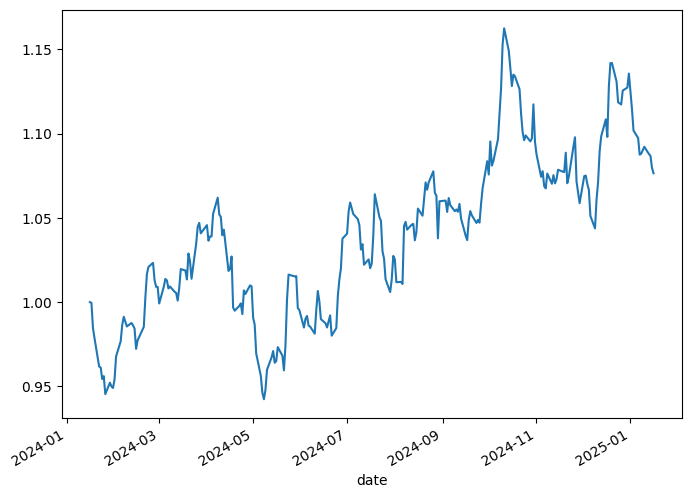

In [39]:
plt.figure(figsize=(8, 6))
df['portfolio_value'].plot()
plt.show()

In [40]:
end = time.time()
runTime = (end - start) // 60   # runTime是多少分钟
print("程序运行时间为：", runTime, "分钟")

程序运行时间为： 187.0 分钟
